In [ ]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.


# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

# **The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


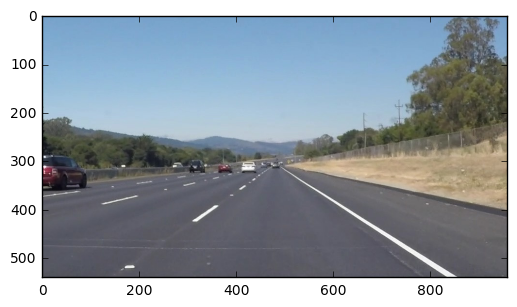

In [2]:
### reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_linear_regression_line(coef, intercept, intersection_x, img, imshape=[540,960], color=[255, 0, 0], thickness=6):

    # Get starting and ending points of regression line, ints.
    print("Coef: ", coef, "Intercept: ", intercept,
          "intersection_x: ", intersection_x)
    point_one = (int(intersection_x), int(intersection_x * coef + intercept))
    point_two = (int((imshape[0] - intercept) / coef),imshape[0])
    print("Point one: ", point_one, "Point two: ", point_two)

    # Draw line using cv2.line
    cv2.line(img, point_one, point_two, color, thickness)
def find_line_fit(slope_intercept):
    """slope_intercept is an array [[slope, intercept], [slope, intercept]...]."""

    # Initialise arrays
    kept_slopes = []
    kept_intercepts = []
    #print("Slope & intercept: ", slope_intercept)
    if len(slope_intercept) == 1:
        return slope_intercept[0][0], slope_intercept[0][1]

    # Remove points with slope not within 1.5 standard deviations of the mean
    slopes = [pair[0] for pair in slope_intercept]
    slope_mean = np.mean(slopes)
    slope_std = np.std(slopes)
    for pair in slope_intercept:
        slope = pair[0]
        if slope - slope_mean < 1.5 * slope_std:
            kept_slopes.append(slope)
            kept_intercepts.append(pair[1])
    if not kept_slopes:
        kept_slopes = slopes
        kept_intercepts = [pair[1] for pair in slope_intercept]
    # Take estimate of slope, intercept to be the mean of remaining values
    slope = np.mean(kept_slopes)
    intercept = np.mean(kept_intercepts)
    #print("Slope: ", slope, "Intercept: ", intercept)
    return slope, intercept

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    positive_slope_intercept = []
    negative_slope_intercept = []
    for line in lines:
        print('type of line',type(line), line)
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            print('slope:',slope)
            if math.isfinite(slope) :
                if slope > 0:
                    positive_slope_intercept.append([slope, y1-slope*x1])
                elif slope < 0:
                    negative_slope_intercept.append([slope, y1-slope*x1])

    if not positive_slope_intercept or not negative_slope_intercept:
        return
    # Get intercept and coefficient of fitted lines
    pos_coef, pos_intercept = find_line_fit(positive_slope_intercept)
    neg_coef, neg_intercept = find_line_fit(negative_slope_intercept)

    intersection_x = (pos_intercept - neg_intercept)/(neg_coef - pos_coef)
    draw_linear_regression_line(pos_coef, pos_intercept, intersection_x, img)
    draw_linear_regression_line(neg_coef, neg_intercept, intersection_x, img)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

In [5]:
## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

SyntaxError: invalid syntax (<ipython-input-5-5ee77d102a54>, line 3)

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    gray_img = grayscale(image)
    kernel_size = 3
    blur_gray = gaussian_blur(gray_img, kernel_size)
    high_threshold, thresh_im = cv2.threshold(blur_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_threshold = 0.5 * high_threshold
    edges = canny(blur_gray, low_threshold, high_threshold)
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 330), (490, 330), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 45   # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30 #minimum number of pixels making up a line
    max_line_gap = 200    # maximum gap in pixels between connectable line segments
    lines = hough_lines(masked_edges,rho,theta,threshold,min_line_length,max_line_gap)

    final_image = weighted_img(lines, image)

    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimesions:', final_image.shape)
    #plt.imshow(final_image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    #plt.show()
    return final_image

Let's try the one with the solid white lane on the right first ...

In [13]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

type of line <class 'numpy.ndarray'> [[618 387 870 539]]
slope: 0.603174603175
type of line <class 'numpy.ndarray'> [[600 380 812 517]]
slope: 0.646226415094
type of line <class 'numpy.ndarray'> [[187 513 416 347]]
slope: -0.724890829694
type of line <class 'numpy.ndarray'> [[200 515 440 335]]
slope: -0.75
type of line <class 'numpy.ndarray'> [[620 388 870 538]]
slope: 0.6
type of line <class 'numpy.ndarray'> [[203 514 445 332]]
slope: -0.752066115702
type of line <class 'numpy.ndarray'> [[187 512 415 347]]
slope: -0.723684210526
type of line <class 'numpy.ndarray'> [[695 442 848 538]]
slope: 0.627450980392
Coef:  0.619212999665 Intercept:  7.10595370224 intersection_x:  478.882066761
Point one:  (478, 303) Point two:  (860, 540)
Coef:  -0.737660288981 Intercept:  656.888238502 intersection_x:  478.882066761
Point one:  (478, 303) Point two:  (158, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video w

  0%|          | 0/222 [00:00<?, ?it/s]  3%|▎         | 7/222 [00:00<00:03, 69.97it/s]

type of line <class 'numpy.ndarray'> [[618 387 870 539]]
slope: 0.603174603175
type of line <class 'numpy.ndarray'> [[600 380 812 517]]
slope: 0.646226415094
type of line <class 'numpy.ndarray'> [[187 513 416 347]]
slope: -0.724890829694
type of line <class 'numpy.ndarray'> [[200 515 440 335]]
slope: -0.75
type of line <class 'numpy.ndarray'> [[620 388 870 538]]
slope: 0.6
type of line <class 'numpy.ndarray'> [[203 514 445 332]]
slope: -0.752066115702
type of line <class 'numpy.ndarray'> [[187 512 415 347]]
slope: -0.723684210526
type of line <class 'numpy.ndarray'> [[695 442 848 538]]
slope: 0.627450980392
Coef:  0.619212999665 Intercept:  7.10595370224 intersection_x:  478.882066761
Point one:  (478, 303) Point two:  (860, 540)
Coef:  -0.737660288981 Intercept:  656.888238502 intersection_x:  478.882066761
Point one:  (478, 303) Point two:  (158, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[628 398 846 539]]
slope: 0

  6%|▋         | 14/222 [00:00<00:03, 68.13it/s]

type of line <class 'numpy.ndarray'> [[589 374 829 523]]
slope: 0.620833333333
type of line <class 'numpy.ndarray'> [[655 423 832 538]]
slope: 0.649717514124
type of line <class 'numpy.ndarray'> [[144 539 428 340]]
slope: -0.700704225352
type of line <class 'numpy.ndarray'> [[586 377 834 539]]
slope: 0.653225806452
type of line <class 'numpy.ndarray'> [[164 539 426 342]]
slope: -0.751908396947
type of line <class 'numpy.ndarray'> [[144 538 390 366]]
slope: -0.69918699187
type of line <class 'numpy.ndarray'> [[569 365 623 400]]
slope: 0.648148148148
type of line <class 'numpy.ndarray'> [[194 517 429 340]]
slope: -0.753191489362
type of line <class 'numpy.ndarray'> [[565 363 856 538]]
slope: 0.601374570447
Coef:  0.634659874501 Intercept:  3.88018874718 intersection_x:  475.509066614
Point one:  (475, 305) Point two:  (844, 540)
Coef:  -0.726247775883 Intercept:  651.004115329 intersection_x:  475.509066614
Point one:  (475, 305) Point two:  (152, 540)
This image is: <class 'numpy.ndarra

  9%|▉         | 21/222 [00:00<00:02, 67.98it/s]

type of line <class 'numpy.ndarray'> [[603 380 857 539]]
slope: 0.625984251969
type of line <class 'numpy.ndarray'> [[591 377 770 497]]
slope: 0.670391061453
type of line <class 'numpy.ndarray'> [[141 538 393 362]]
slope: -0.698412698413
type of line <class 'numpy.ndarray'> [[161 538 411 350]]
slope: -0.752
type of line <class 'numpy.ndarray'> [[598 378 842 530]]
slope: 0.622950819672
type of line <class 'numpy.ndarray'> [[578 369 739 477]]
slope: 0.670807453416
type of line <class 'numpy.ndarray'> [[167 535 424 342]]
slope: -0.750972762646
type of line <class 'numpy.ndarray'> [[763 491 835 539]]
slope: 0.666666666667
type of line <class 'numpy.ndarray'> [[142 539 412 350]]
slope: -0.7
Coef:  0.651360050635 Intercept:  -9.51751723212 intersection_x:  478.030515505
Point one:  (478, 301) Point two:  (843, 540)
Coef:  -0.725346365265 Intercept:  648.59016046 intersection_x:  478.030515505
Point one:  (478, 301) Point two:  (149, 540)
This image is: <class 'numpy.ndarray'> with dimesions:

 13%|█▎        | 28/222 [00:00<00:02, 67.60it/s] 16%|█▌        | 35/222 [00:00<00:02, 67.66it/s]

644.490086938 intersection_x:  481.513685776
Point one:  (481, 306) Point two:  (148, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[594 376 855 539]]
slope: 0.624521072797
type of line <class 'numpy.ndarray'> [[571 366 734 472]]
slope: 0.650306748466
type of line <class 'numpy.ndarray'> [[610 385 856 538]]
slope: 0.621951219512
type of line <class 'numpy.ndarray'> [[565 363 834 538]]
slope: 0.650557620818
type of line <class 'numpy.ndarray'> [[162 528 434 338]]
slope: -0.698529411765
type of line <class 'numpy.ndarray'> [[768 496 834 539]]
slope: 0.651515151515
Coef:  0.639770362622 Intercept:  -0.721921328754 intersection_x:  479.626237947
Point one:  (479, 306) Point two:  (845, 540)
Coef:  -0.698529411765 Intercept:  641.161764706 intersection_x:  479.626237947
Point one:  (479, 306) Point two:  (144, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[596 

 19%|█▉        | 42/222 [00:00<00:02, 67.95it/s]

type of line <class 'numpy.ndarray'> [[648 417 834 538]]
slope: 0.650537634409
type of line <class 'numpy.ndarray'> [[600 379 855 538]]
slope: 0.623529411765
type of line <class 'numpy.ndarray'> [[590 378 741 477]]
slope: 0.655629139073
type of line <class 'numpy.ndarray'> [[576 368 622 398]]
slope: 0.652173913043
type of line <class 'numpy.ndarray'> [[142 539 426 341]]
slope: -0.697183098592
type of line <class 'numpy.ndarray'> [[742 479 831 537]]
slope: 0.651685393258
Coef:  0.643175583253 Intercept:  -2.74845978869 intersection_x:  478.042533292
Point one:  (478, 304) Point two:  (843, 540)
Coef:  -0.697183098592 Intercept:  638.0 intersection_x:  478.042533292
Point one:  (478, 304) Point two:  (140, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[598 378 854 538]]
slope: 0.625
type of line <class 'numpy.ndarray'> [[580 370 817 529]]
slope: 0.670886075949
type of line <class 'numpy.ndarray'> [[576 368 719 464]]
slope:

 22%|██▏       | 49/222 [00:00<00:02, 68.01it/s]

type of line <class 'numpy.ndarray'> [[582 371 832 539]]
slope: 0.672
type of line <class 'numpy.ndarray'> [[600 379 854 538]]
slope: 0.625984251969
type of line <class 'numpy.ndarray'> [[576 368 723 467]]
slope: 0.673469387755
type of line <class 'numpy.ndarray'> [[751 484 832 538]]
slope: 0.666666666667
type of line <class 'numpy.ndarray'> [[257 459 422 343]]
slope: -0.70303030303
type of line <class 'numpy.ndarray'> [[273 458 431 339]]
slope: -0.753164556962
Coef:  0.659530076598 Intercept:  -13.3198962987 intersection_x:  479.210918711
Point one:  (479, 302) Point two:  (838, 540)
Coef:  -0.728097429996 Intercept:  651.646355965 intersection_x:  479.210918711
Point one:  (479, 302) Point two:  (153, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[674 426 855 539]]
slope: 0.624309392265
type of line <class 'numpy.ndarray'> [[580 370 790 511]]
slope: 0.671428571429
type of line <class 'numpy.ndarray'> [[603 380 854 537]

 25%|██▌       | 56/222 [00:00<00:02, 61.16it/s]

0.628099173554
type of line <class 'numpy.ndarray'> [[767 485 853 539]]
slope: 0.627906976744
type of line <class 'numpy.ndarray'> [[600 379 760 479]]
slope: 0.625
type of line <class 'numpy.ndarray'> [[253 455 417 345]]
slope: -0.670731707317
type of line <class 'numpy.ndarray'> [[269 455 421 345]]
slope: -0.723684210526
Coef:  0.642456263059 Intercept:  -4.79272847027 intersection_x:  479.206509533
Point one:  (479, 303) Point two:  (847, 540)
Coef:  -0.697207958922 Intercept:  637.183087291 intersection_x:  479.206509533
Point one:  (479, 303) Point two:  (139, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[594 376 851 537]]
slope: 0.626459143969
type of line <class 'numpy.ndarray'> [[576 368 830 539]]
slope: 0.673228346457
type of line <class 'numpy.ndarray'> [[601 381 852 538]]
slope: 0.625498007968
type of line <class 'numpy.ndarray'> [[573 367 704 455]]
slope: 0.671755725191
type of line <class 'numpy.ndarray'> [[

 28%|██▊       | 62/222 [00:01<00:03, 41.30it/s]

slope: -0.675
Coef:  0.652992794036 Intercept:  -6.86678339301 intersection_x:  478.143082858
Point one:  (478, 305) Point two:  (837, 540)
Coef:  -0.690059399022 Intercept:  635.304332635 intersection_x:  478.143082858
Point one:  (478, 305) Point two:  (138, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[565 363 826 539]]
slope: 0.674329501916
type of line <class 'numpy.ndarray'> [[658 419 848 538]]
slope: 0.626315789474
type of line <class 'numpy.ndarray'> [[226 475 417 346]]
slope: -0.675392670157
type of line <class 'numpy.ndarray'> [[560 361 767 500]]
slope: 0.671497584541
type of line <class 'numpy.ndarray'> [[627 399 732 465]]
slope: 0.628571428571
type of line <class 'numpy.ndarray'> [[239 476 433 340]]
slope: -0.701030927835
type of line <class 'numpy.ndarray'> [[703 448 848 539]]
slope: 0.627586206897
type of line <class 'numpy.ndarray'> [[589 374 637 404]]
slope: 0.625
type of line <class 'numpy.ndarray'> [[2

 31%|███       | 68/222 [00:01<00:03, 44.25it/s]

[[580 370 787 500]]
slope: 0.628019323671
type of line <class 'numpy.ndarray'> [[564 363 824 538]]
slope: 0.673076923077
type of line <class 'numpy.ndarray'> [[769 490 845 538]]
slope: 0.631578947368
type of line <class 'numpy.ndarray'> [[264 455 427 341]]
slope: -0.699386503067
type of line <class 'numpy.ndarray'> [[587 373 739 471]]
slope: 0.644736842105
type of line <class 'numpy.ndarray'> [[335 398 420 345]]
slope: -0.623529411765
Coef:  0.649822029886 Intercept:  -5.36377527135 intersection_x:  479.397212063
Point one:  (479, 306) Point two:  (839, 540)
Coef:  -0.661457957416 Intercept:  623.260194875 intersection_x:  479.397212063
Point one:  (479, 306) Point two:  (125, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[629 401 847 538]]
slope: 0.628440366972
type of line <class 'numpy.ndarray'> [[566 364 825 538]]
slope: 0.671814671815
type of line <class 'numpy.ndarray'> [[560 361 825 539]]
slope: 0.671698113208
typ

 33%|███▎      | 74/222 [00:01<00:03, 46.52it/s]

type of line <class 'numpy.ndarray'> [[562 362 824 538]]
slope: 0.671755725191
type of line <class 'numpy.ndarray'> [[585 372 763 487]]
slope: 0.64606741573
type of line <class 'numpy.ndarray'> [[715 455 832 530]]
slope: 0.641025641026
type of line <class 'numpy.ndarray'> [[556 359 794 519]]
slope: 0.672268907563
type of line <class 'numpy.ndarray'> [[163 511 422 343]]
slope: -0.648648648649
type of line <class 'numpy.ndarray'> [[187 509 432 338]]
slope: -0.697959183673
type of line <class 'numpy.ndarray'> [[584 372 686 438]]
slope: 0.647058823529
type of line <class 'numpy.ndarray'> [[780 496 846 539]]
slope: 0.651515151515
Coef:  0.654948610759 Intercept:  -9.60919547014 intersection_x:  480.129516853
Point one:  (480, 304) Point two:  (839, 540)
Coef:  -0.673303916161 Intercept:  628.124048538 intersection_x:  480.129516853
Point one:  (480, 304) Point two:  (130, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[556 359

 36%|███▌      | 80/222 [00:01<00:02, 48.46it/s]

[[557 360 812 538]]
slope: 0.698039215686
type of line <class 'numpy.ndarray'> [[569 365 835 538]]
slope: 0.65037593985
type of line <class 'numpy.ndarray'> [[553 358 751 496]]
slope: 0.69696969697
type of line <class 'numpy.ndarray'> [[225 477 425 342]]
slope: -0.675
type of line <class 'numpy.ndarray'> [[654 421 834 538]]
slope: 0.65
type of line <class 'numpy.ndarray'> [[319 406 405 351]]
slope: -0.639534883721
type of line <class 'numpy.ndarray'> [[723 475 814 538]]
slope: 0.692307692308
Coef:  0.677538508963 Intercept:  -18.1868913749 intersection_x:  477.695057424
Point one:  (477, 305) Point two:  (823, 540)
Coef:  -0.65726744186 Intercept:  619.443313953 intersection_x:  477.695057424
Point one:  (477, 305) Point two:  (120, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[556 359 813 539]]
slope: 0.700389105058
type of line <class 'numpy.ndarray'> [[621 399 835 538]]
slope: 0.64953271028
type of line <class 'numpy

 39%|███▊      | 86/222 [00:01<00:03, 35.47it/s] 41%|████▏     | 92/222 [00:01<00:03, 39.50it/s]

type of line <class 'numpy.ndarray'> [[551 357 811 539]]
slope: 0.7
type of line <class 'numpy.ndarray'> [[567 364 789 509]]
slope: 0.653153153153
type of line <class 'numpy.ndarray'> [[557 360 811 538]]
slope: 0.700787401575
type of line <class 'numpy.ndarray'> [[226 466 428 340]]
slope: -0.623762376238
type of line <class 'numpy.ndarray'> [[236 469 417 347]]
slope: -0.674033149171
type of line <class 'numpy.ndarray'> [[751 485 832 538]]
slope: 0.654320987654
type of line <class 'numpy.ndarray'> [[569 365 729 469]]
slope: 0.65
type of line <class 'numpy.ndarray'> [[237 469 430 339]]
slope: -0.673575129534
type of line <class 'numpy.ndarray'> [[255 447 418 345]]
slope: -0.625766871166
Coef:  0.671652308476 Intercept:  -15.3242964487 intersection_x:  479.119700254
Point one:  (479, 306) Point two:  (826, 540)
Coef:  -0.649284381527 Intercept:  617.56249452 intersection_x:  479.119700254
Point one:  (479, 306) Point two:  (119, 540)
This image is: <class 'numpy.ndarray'> with dimesions: 

 44%|████▍     | 98/222 [00:01<00:02, 42.45it/s]

type of line <class 'numpy.ndarray'> [[573 367 809 526]]
slope: 0.673728813559
type of line <class 'numpy.ndarray'> [[596 389 808 538]]
slope: 0.702830188679
type of line <class 'numpy.ndarray'> [[575 368 829 539]]
slope: 0.673228346457
type of line <class 'numpy.ndarray'> [[562 364 732 484]]
slope: 0.705882352941
type of line <class 'numpy.ndarray'> [[181 509 438 336]]
slope: -0.673151750973
type of line <class 'numpy.ndarray'> [[706 467 808 539]]
slope: 0.705882352941
type of line <class 'numpy.ndarray'> [[165 511 424 342]]
slope: -0.65250965251
type of line <class 'numpy.ndarray'> [[164 510 411 350]]
slope: -0.647773279352
Coef:  0.692310410916 Intercept:  -26.4197050729 intersection_x:  480.203155261
Point one:  (480, 306) Point two:  (818, 540)
Coef:  -0.657811560945 Intercept:  621.913125801 intersection_x:  480.203155261
Point one:  (480, 306) Point two:  (124, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[575 36

 47%|████▋     | 104/222 [00:02<00:02, 46.30it/s] 50%|████▉     | 110/222 [00:02<00:02, 49.57it/s]

type of line <class 'numpy.ndarray'> [[569 366 812 537]]
slope: 0.703703703704
type of line <class 'numpy.ndarray'> [[587 373 833 539]]
slope: 0.674796747967
type of line <class 'numpy.ndarray'> [[617 401 813 539]]
slope: 0.704081632653
type of line <class 'numpy.ndarray'> [[584 372 710 457]]
slope: 0.674603174603
type of line <class 'numpy.ndarray'> [[335 410 449 330]]
slope: -0.701754385965
type of line <class 'numpy.ndarray'> [[212 479 451 330]]
slope: -0.623430962343
Coef:  0.689296314732 Intercept:  -28.2249299449 intersection_x:  485.507668898
Point one:  (485, 306) Point two:  (824, 540)
Coef:  -0.662592674154 Intercept:  628.127541657 intersection_x:  485.507668898
Point one:  (485, 306) Point two:  (133, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[591 375 835 539]]
slope: 0.672131147541
type of line <class 'numpy.ndarray'> [[614 398 815 539]]
slope: 0.701492537313
type of line <class 'numpy.ndarray'> [[587 37

 52%|█████▏    | 116/222 [00:02<00:02, 51.61it/s] 55%|█████▍    | 122/222 [00:02<00:01, 51.98it/s]

[[587 373 824 539]]
slope: 0.700421940928
type of line <class 'numpy.ndarray'> [[613 385 770 490]]
slope: 0.668789808917
type of line <class 'numpy.ndarray'> [[637 400 829 529]]
slope: 0.671875
type of line <class 'numpy.ndarray'> [[329 404 430 339]]
slope: -0.643564356436
type of line <class 'numpy.ndarray'> [[230 476 441 334]]
slope: -0.672985781991
type of line <class 'numpy.ndarray'> [[792 503 844 538]]
slope: 0.673076923077
type of line <class 'numpy.ndarray'> [[239 474 437 336]]
slope: -0.69696969697
Coef:  0.671247243998 Intercept:  -27.6764836477 intersection_x:  489.197083099
Point one:  (489, 300) Point two:  (845, 540)
Coef:  -0.671173278465 Intercept:  629.031720234 intersection_x:  489.197083099
Point one:  (489, 300) Point two:  (132, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[674 433 825 538]]
slope: 0.695364238411
type of line <class 'numpy.ndarray'> [[585 372 803 524]]
slope: 0.697247706422
type of l

 58%|█████▊    | 128/222 [00:02<00:01, 52.37it/s] 60%|██████    | 134/222 [00:02<00:01, 53.15it/s]

type of line <class 'numpy.ndarray'> [[607 382 858 538]]
slope: 0.621513944223
type of line <class 'numpy.ndarray'> [[578 369 788 506]]
slope: 0.652380952381
type of line <class 'numpy.ndarray'> [[730 469 836 538]]
slope: 0.650943396226
type of line <class 'numpy.ndarray'> [[603 380 857 539]]
slope: 0.625984251969
type of line <class 'numpy.ndarray'> [[582 371 711 455]]
slope: 0.651162790698
type of line <class 'numpy.ndarray'> [[266 451 439 335]]
slope: -0.670520231214
type of line <class 'numpy.ndarray'> [[278 451 444 335]]
slope: -0.698795180723
Coef:  0.640397067099 Intercept:  -2.99381639759 intersection_x:  483.22948627
Point one:  (483, 306) Point two:  (847, 540)
Coef:  -0.684657705968 Intercept:  637.311720872 intersection_x:  483.22948627
Point one:  (483, 306) Point two:  (142, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[603 380 858 539]]
slope: 0.623529411765
type of line <class 'numpy.ndarray'> [[578 369 

 63%|██████▎   | 140/222 [00:02<00:01, 54.69it/s] 66%|██████▌   | 146/222 [00:02<00:01, 55.16it/s]

0.62037037037
type of line <class 'numpy.ndarray'> [[755 470 865 538]]
slope: 0.618181818182
type of line <class 'numpy.ndarray'> [[169 532 438 336]]
slope: -0.728624535316
type of line <class 'numpy.ndarray'> [[622 389 751 469]]
slope: 0.62015503876
type of line <class 'numpy.ndarray'> [[295 434 428 341]]
slope: -0.699248120301
Coef:  0.619569075771 Intercept:  3.01518414115 intersection_x:  483.457123689
Point one:  (483, 302) Point two:  (866, 540)
Coef:  -0.713936327808 Intercept:  647.707870979 intersection_x:  483.457123689
Point one:  (483, 302) Point two:  (150, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[587 373 842 538]]
slope: 0.647058823529
type of line <class 'numpy.ndarray'> [[595 377 864 538]]
slope: 0.598513011152
type of line <class 'numpy.ndarray'> [[623 391 768 479]]
slope: 0.606896551724
type of line <class 'numpy.ndarray'> [[620 395 819 524]]
slope: 0.64824120603
type of line <class 'numpy.ndarray

 68%|██████▊   | 152/222 [00:02<00:01, 53.27it/s] 71%|███████   | 158/222 [00:03<00:01, 52.77it/s]

 [[313 434 447 333]]
slope: -0.753731343284
type of line <class 'numpy.ndarray'> [[615 389 801 506]]
slope: 0.629032258065
type of line <class 'numpy.ndarray'> [[161 537 436 337]]
slope: -0.727272727273
Coef:  0.61803485959 Intercept:  6.99691586055 intersection_x:  482.141851563
Point one:  (482, 304) Point two:  (862, 540)
Coef:  -0.740502035278 Intercept:  662.004409769 intersection_x:  482.141851563
Point one:  (482, 304) Point two:  (164, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[642 407 849 537]]
slope: 0.628019323671
type of line <class 'numpy.ndarray'> [[649 405 871 539]]
slope: 0.603603603604
type of line <class 'numpy.ndarray'> [[627 391 872 538]]
slope: 0.6
type of line <class 'numpy.ndarray'> [[277 451 447 332]]
slope: -0.7
type of line <class 'numpy.ndarray'> [[682 433 850 538]]
slope: 0.625
type of line <class 'numpy.ndarray'> [[607 384 697 441]]
slope: 0.633333333333
type of line <class 'numpy.ndarray

 74%|███████▍  | 164/222 [00:03<00:01, 54.33it/s]

<class 'numpy.ndarray'> [[652 402 824 505]]
slope: 0.598837209302
type of line <class 'numpy.ndarray'> [[622 389 859 537]]
slope: 0.62447257384
type of line <class 'numpy.ndarray'> [[202 520 450 333]]
slope: -0.754032258065
type of line <class 'numpy.ndarray'> [[186 534 445 332]]
slope: -0.779922779923
type of line <class 'numpy.ndarray'> [[159 539 414 354]]
slope: -0.725490196078
Coef:  0.610868822092 Intercept:  6.65828745653 intersection_x:  485.272029148
Point one:  (485, 303) Point two:  (873, 540)
Coef:  -0.753148411355 Intercept:  668.577698124 intersection_x:  485.272029148
Point one:  (485, 303) Point two:  (170, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[616 386 861 539]]
slope: 0.624489795918
type of line <class 'numpy.ndarray'> [[654 403 852 521]]
slope: 0.59595959596
type of line <class 'numpy.ndarray'> [[710 435 883 539]]
slope: 0.601156069364
type of line <class 'numpy.ndarray'> [[313 433 447 332]]
slo

 77%|███████▋  | 170/222 [00:03<00:01, 43.70it/s] 79%|███████▉  | 175/222 [00:03<00:01, 44.31it/s]

 0.6
type of line <class 'numpy.ndarray'> [[242 488 451 330]]
slope: -0.755980861244
type of line <class 'numpy.ndarray'> [[254 488 418 360]]
slope: -0.780487804878
type of line <class 'numpy.ndarray'> [[242 487 450 330]]
slope: -0.754807692308
type of line <class 'numpy.ndarray'> [[257 487 337 424]]
slope: -0.7875
Coef:  0.59260712249 Intercept:  22.48125381 intersection_x:  481.963385527
Point one:  (481, 308) Point two:  (873, 540)
Coef:  -0.769694089607 Intercept:  679.0605581 intersection_x:  481.963385527
Point one:  (481, 308) Point two:  (180, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[632 393 885 539]]
slope: 0.577075098814
type of line <class 'numpy.ndarray'> [[593 376 864 538]]
slope: 0.59778597786
type of line <class 'numpy.ndarray'> [[196 522 450 331]]
slope: -0.751968503937
type of line <class 'numpy.ndarray'> [[209 524 408 368]]
slope: -0.78391959799
type of line <class 'numpy.ndarray'> [[196 521 448 3

 82%|████████▏ | 182/222 [00:03<00:00, 48.26it/s] 85%|████████▍ | 188/222 [00:03<00:00, 50.95it/s]


type of line <class 'numpy.ndarray'> [[307 441 442 335]]
slope: -0.785185185185
type of line <class 'numpy.ndarray'> [[634 400 864 539]]
slope: 0.604347826087
Coef:  0.594174409771 Intercept:  20.8709611676 intersection_x:  479.894933139
Point one:  (479, 306) Point two:  (873, 540)
Coef:  -0.811291779584 Intercept:  695.347064137 intersection_x:  479.894933139
Point one:  (479, 306) Point two:  (191, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[632 397 867 539]]
slope: 0.604255319149
type of line <class 'numpy.ndarray'> [[641 397 888 539]]
slope: 0.574898785425
type of line <class 'numpy.ndarray'> [[650 401 888 538]]
slope: 0.575630252101
type of line <class 'numpy.ndarray'> [[612 384 867 538]]
slope: 0.603921568627
type of line <class 'numpy.ndarray'> [[282 460 442 335]]
slope: -0.78125
type of line <class 'numpy.ndarray'> [[294 461 451 330]]
slope: -0.834394904459
Coef:  0.589676481326 Intercept:  21.2102132437 int

 87%|████████▋ | 194/222 [00:03<00:00, 53.31it/s] 91%|█████████ | 201/222 [00:03<00:00, 55.91it/s]


type of line <class 'numpy.ndarray'> [[666 412 881 537]]
slope: 0.581395348837
type of line <class 'numpy.ndarray'> [[294 458 442 334]]
slope: -0.837837837838
type of line <class 'numpy.ndarray'> [[694 422 903 538]]
slope: 0.555023923445
type of line <class 'numpy.ndarray'> [[282 456 442 336]]
slope: -0.75
type of line <class 'numpy.ndarray'> [[697 431 882 538]]
slope: 0.578378378378
type of line <class 'numpy.ndarray'> [[281 456 442 335]]
slope: -0.751552795031
type of line <class 'numpy.ndarray'> [[641 397 829 506]]
slope: 0.579787234043
Coef:  0.569516055282 Intercept:  30.5845827902 intersection_x:  481.049000043
Point one:  (481, 304) Point two:  (894, 540)
Coef:  -0.779796877623 Intercept:  679.670219909 intersection_x:  481.049000043
Point one:  (481, 304) Point two:  (179, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[625 390 811 501]]
slope: 0.596774193548
type of line <class 'numpy.ndarray'> [[686 420 899 539

 94%|█████████▎| 208/222 [00:04<00:00, 57.64it/s] 97%|█████████▋| 215/222 [00:04<00:00, 59.86it/s]

type of line <class 'numpy.ndarray'> [[670 414 876 537]]
slope: 0.597087378641
type of line <class 'numpy.ndarray'> [[756 458 901 539]]
slope: 0.558620689655
type of line <class 'numpy.ndarray'> [[204 516 452 330]]
slope: -0.75
type of line <class 'numpy.ndarray'> [[221 519 327 433]]
slope: -0.811320754717
type of line <class 'numpy.ndarray'> [[682 416 901 538]]
slope: 0.557077625571
type of line <class 'numpy.ndarray'> [[634 394 797 491]]
slope: 0.59509202454
Coef:  0.576969429602 Intercept:  25.6047326835 intersection_x:  484.702241612
Point one:  (484, 305) Point two:  (891, 540)
Coef:  -0.780660377358 Intercept:  683.650943396 intersection_x:  484.702241612
Point one:  (484, 305) Point two:  (184, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[687 418 903 538]]
slope: 0.555555555556
type of line <class 'numpy.ndarray'> [[673 415 879 538]]
slope: 0.597087378641
type of line <class 'numpy.ndarray'> [[196 539 307 449]]


100%|█████████▉| 221/222 [00:04<00:00, 52.43it/s]


 <class 'numpy.ndarray'> [[641 397 896 538]]
slope: 0.552941176471
type of line <class 'numpy.ndarray'> [[609 384 875 538]]
slope: 0.578947368421
type of line <class 'numpy.ndarray'> [[198 539 433 342]]
slope: -0.83829787234
type of line <class 'numpy.ndarray'> [[178 538 357 398]]
slope: -0.782122905028
type of line <class 'numpy.ndarray'> [[603 380 871 535]]
slope: 0.578358208955
type of line <class 'numpy.ndarray'> [[650 401 898 538]]
slope: 0.552419354839
type of line <class 'numpy.ndarray'> [[198 538 421 351]]
slope: -0.838565022422
Coef:  0.565666527171 Intercept:  36.7907944672 intersection_x:  475.42620235
Point one:  (475, 305) Point two:  (889, 540)
Coef:  -0.819661933263 Intercept:  695.412243419 intersection_x:  475.42620235
Point one:  (475, 305) Point two:  (189, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[641 397 896 538]]
slope: 0.552941176471
type of line <class 'numpy.ndarray'> [[635 399 875 538]]
slo

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [15]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

type of line <class 'numpy.ndarray'> [[104 538 451 330]]
slope: -0.599423631124
type of line <class 'numpy.ndarray'> [[112 533 450 330]]
slope: -0.600591715976
type of line <class 'numpy.ndarray'> [[162 514 414 356]]
slope: -0.626984126984
type of line <class 'numpy.ndarray'> [[311 419 449 332]]
slope: -0.630434782609
type of line <class 'numpy.ndarray'> [[609 386 774 497]]
slope: 0.672727272727
type of line <class 'numpy.ndarray'> [[573 367 758 497]]
slope: 0.702702702703
type of line <class 'numpy.ndarray'> [[126 538 322 416]]
slope: -0.622448979592
type of line <class 'numpy.ndarray'> [[124 538 414 357]]
slope: -0.624137931034
Coef:  0.687714987715 Intercept:  -29.6697788698 intersection_x:  490.54032183
Point one:  (490, 307) Point two:  (828, 540)
Coef:  -0.61733686122 Intercept:  610.510775111 intersection_x:  490.54032183
Point one:  (490, 307) Point two:  (114, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
[MoviePy] >>>> Building video yellow.mp4
[Mo

  0%|          | 0/682 [00:00<?, ?it/s]  1%|          | 7/682 [00:00<00:09, 69.06it/s]

type of line <class 'numpy.ndarray'> [[104 538 451 330]]
slope: -0.599423631124
type of line <class 'numpy.ndarray'> [[112 533 450 330]]
slope: -0.600591715976
type of line <class 'numpy.ndarray'> [[162 514 414 356]]
slope: -0.626984126984
type of line <class 'numpy.ndarray'> [[311 419 449 332]]
slope: -0.630434782609
type of line <class 'numpy.ndarray'> [[609 386 774 497]]
slope: 0.672727272727
type of line <class 'numpy.ndarray'> [[573 367 758 497]]
slope: 0.702702702703
type of line <class 'numpy.ndarray'> [[126 538 322 416]]
slope: -0.622448979592
type of line <class 'numpy.ndarray'> [[124 538 414 357]]
slope: -0.624137931034
Coef:  0.687714987715 Intercept:  -29.6697788698 intersection_x:  490.54032183
Point one:  (490, 307) Point two:  (828, 540)
Coef:  -0.61733686122 Intercept:  610.510775111 intersection_x:  490.54032183
Point one:  (490, 307) Point two:  (114, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[108 5

  2%|▏         | 14/682 [00:00<00:09, 67.92it/s]  3%|▎         | 21/682 [00:00<00:09, 68.23it/s]

<class 'numpy.ndarray'> [[619 389 818 513]]
slope: 0.623115577889
Coef:  0.638592441146 Intercept:  -4.66829843238 intersection_x:  487.122602665
Point one:  (487, 306) Point two:  (852, 540)
Coef:  -0.661448954981 Intercept:  628.611250021 intersection_x:  487.122602665
Point one:  (487, 306) Point two:  (133, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[129 538 446 332]]
slope: -0.649842271293
type of line <class 'numpy.ndarray'> [[632 396 858 537]]
slope: 0.62389380531
type of line <class 'numpy.ndarray'> [[130 539 442 336]]
slope: -0.650641025641
type of line <class 'numpy.ndarray'> [[149 538 413 360]]
slope: -0.674242424242
type of line <class 'numpy.ndarray'> [[586 373 839 538]]
slope: 0.652173913043
type of line <class 'numpy.ndarray'> [[623 399 839 539]]
slope: 0.648148148148
type of line <class 'numpy.ndarray'> [[362 392 435 342]]
slope: -0.684931506849
type of line <class 'numpy.ndarray'> [[299 435 423 351]]


  4%|▍         | 28/682 [00:00<00:09, 67.29it/s]

 0.600823045267
type of line <class 'numpy.ndarray'> [[138 538 439 335]]
slope: -0.674418604651
type of line <class 'numpy.ndarray'> [[198 499 431 342]]
slope: -0.673819742489
type of line <class 'numpy.ndarray'> [[621 396 848 538]]
slope: 0.625550660793
type of line <class 'numpy.ndarray'> [[313 428 401 366]]
slope: -0.704545454545
Coef:  0.612909440805 Intercept:  11.9263429854 intersection_x:  482.898879772
Point one:  (482, 307) Point two:  (861, 540)
Coef:  -0.6881419273 Intercept:  640.202591169 intersection_x:  482.898879772
Point one:  (482, 307) Point two:  (145, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[139 538 432 340]]
slope: -0.675767918089
type of line <class 'numpy.ndarray'> [[233 487 416 354]]
slope: -0.726775956284
type of line <class 'numpy.ndarray'> [[635 403 851 538]]
slope: 0.625
type of line <class 'numpy.ndarray'> [[159 539 429 343]]
slope: -0.725925925926
type of line <class 'numpy.ndarray'> 

  5%|▌         | 35/682 [00:00<00:09, 67.53it/s]

type of line <class 'numpy.ndarray'> [[193 516 402 364]]
slope: -0.727272727273
type of line <class 'numpy.ndarray'> [[139 538 428 343]]
slope: -0.674740484429
type of line <class 'numpy.ndarray'> [[141 538 421 349]]
slope: -0.675
type of line <class 'numpy.ndarray'> [[160 539 420 350]]
slope: -0.726923076923
type of line <class 'numpy.ndarray'> [[656 406 875 538]]
slope: 0.602739726027
type of line <class 'numpy.ndarray'> [[653 408 855 539]]
slope: 0.648514851485
type of line <class 'numpy.ndarray'> [[366 384 435 337]]
slope: -0.68115942029
Coef:  0.625627288756 Intercept:  -2.43872914689 intersection_x:  487.225183567
Point one:  (487, 302) Point two:  (867, 540)
Coef:  -0.697019141783 Intercept:  641.987920767 intersection_x:  487.225183567
Point one:  (487, 302) Point two:  (146, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[143 536 428 343]]
slope: -0.677192982456
type of line <class 'numpy.ndarray'> [[162 538 415 

  6%|▌         | 42/682 [00:00<00:09, 66.08it/s]  7%|▋         | 49/682 [00:00<00:09, 65.94it/s]

<class 'numpy.ndarray'> [[660 410 880 537]]
slope: 0.577272727273
Coef:  0.592741688548 Intercept:  19.0662985484 intersection_x:  477.734223326
Point one:  (477, 302) Point two:  (878, 540)
Coef:  -0.733862207746 Intercept:  652.830380605 intersection_x:  477.734223326
Point one:  (477, 302) Point two:  (153, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[142 539 422 343]]
slope: -0.7
type of line <class 'numpy.ndarray'> [[163 539 410 353]]
slope: -0.753036437247
type of line <class 'numpy.ndarray'> [[179 528 390 369]]
slope: -0.75355450237
type of line <class 'numpy.ndarray'> [[142 538 418 345]]
slope: -0.699275362319
type of line <class 'numpy.ndarray'> [[163 538 420 344]]
slope: -0.75486381323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[143 538 422 343]]
slope: -0.698924731183
type of line <class 'numpy.ndarray'> [[201 512 380 377]]
slope: -0.75418994413

  8%|▊         | 56/682 [00:00<00:13, 46.39it/s]

type of line <class 'numpy.ndarray'> [[165 538 428 340]]
slope: -0.752851711027
type of line <class 'numpy.ndarray'> [[165 539 405 358]]
slope: -0.754166666667
type of line <class 'numpy.ndarray'> [[273 448 413 347]]
slope: -0.721428571429
type of line <class 'numpy.ndarray'> [[621 389 873 534]]
slope: 0.575396825397
type of line <class 'numpy.ndarray'> [[621 392 854 537]]
slope: 0.622317596567
type of line <class 'numpy.ndarray'> [[163 526 302 426]]
slope: -0.719424460432
type of line <class 'numpy.ndarray'> [[623 392 856 537]]
slope: 0.622317596567
type of line <class 'numpy.ndarray'> [[144 539 233 475]]
slope: -0.719101123596
type of line <class 'numpy.ndarray'> [[707 437 873 536]]
slope: 0.596385542169
Coef:  0.604104390175 Intercept:  14.2177257466 intersection_x:  476.312340899
Point one:  (476, 301) Point two:  (870, 540)
Coef:  -0.73339450663 Intercept:  651.284956234 intersection_x:  476.312340899
Point one:  (476, 301) Point two:  (151, 540)
This image is: <class 'numpy.ndarr

  9%|▉         | 63/682 [00:01<00:12, 50.17it/s] 10%|█         | 69/682 [00:01<00:11, 52.38it/s]

 <class 'numpy.ndarray'> [[161 539 336 408]]
slope: -0.748571428571
type of line <class 'numpy.ndarray'> [[212 502 428 340]]
slope: -0.75
type of line <class 'numpy.ndarray'> [[141 539 402 356]]
slope: -0.701149425287
type of line <class 'numpy.ndarray'> [[609 387 773 489]]
slope: 0.621951219512
Coef:  0.621951219512 Intercept:  8.23170731707 intersection_x:  475.616793895
Point one:  (475, 304) Point two:  (855, 540)
Coef:  -0.724749054044 Intercept:  648.744973763 intersection_x:  475.616793895
Point one:  (475, 304) Point two:  (150, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[140 539 417 345]]
slope: -0.70036101083
type of line <class 'numpy.ndarray'> [[241 478 427 342]]
slope: -0.731182795699
type of line <class 'numpy.ndarray'> [[140 538 413 347]]
slope: -0.699633699634
type of line <class 'numpy.ndarray'> [[160 538 353 397]]
slope: -0.730569948187
type of line <class 'numpy.ndarray'> [[619 393 836 529]]
slope: 

 11%|█         | 75/682 [00:01<00:12, 50.53it/s] 12%|█▏        | 81/682 [00:01<00:11, 50.49it/s]

 <class 'numpy.ndarray'> [[137 538 437 336]]
slope: -0.673333333333
type of line <class 'numpy.ndarray'> [[249 473 425 345]]
slope: -0.727272727273
type of line <class 'numpy.ndarray'> [[157 538 434 337]]
slope: -0.725631768953
type of line <class 'numpy.ndarray'> [[210 501 419 344]]
slope: -0.751196172249
type of line <class 'numpy.ndarray'> [[575 368 799 508]]
slope: 0.625
type of line <class 'numpy.ndarray'> [[613 388 812 503]]
slope: 0.577889447236
type of line <class 'numpy.ndarray'> [[154 526 388 368]]
slope: -0.675213675214
Coef:  0.601444723618 Intercept:  21.1893844221 intersection_x:  475.474106611
Point one:  (475, 307) Point two:  (862, 540)
Coef:  -0.710529535404 Intercept:  644.999173128 intersection_x:  475.474106611
Point one:  (475, 307) Point two:  (147, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[137 539 433 339]]
slope: -0.675675675676
type of line <class 'numpy.ndarray'> [[178 524 437 336]]
slope:

 13%|█▎        | 87/682 [00:01<00:11, 52.40it/s]

type of line <class 'numpy.ndarray'> [[135 539 434 337]]
slope: -0.675585284281
type of line <class 'numpy.ndarray'> [[156 539 426 343]]
slope: -0.725925925926
type of line <class 'numpy.ndarray'> [[135 538 430 339]]
slope: -0.674576271186
type of line <class 'numpy.ndarray'> [[234 483 435 337]]
slope: -0.726368159204
type of line <class 'numpy.ndarray'> [[323 410 411 350]]
slope: -0.681818181818
type of line <class 'numpy.ndarray'> [[585 375 684 441]]
slope: 0.666666666667
Coef:  0.666666666667 Intercept:  -15.0 intersection_x:  479.598428263
Point one:  (479, 304) Point two:  (832, 540)
Coef:  -0.696854764483 Intercept:  638.942735283 intersection_x:  479.598428263
Point one:  (479, 304) Point two:  (141, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[208 501 434 337]]
slope: -0.725663716814
type of line <class 'numpy.ndarray'> [[134 538 396 361]]
slope: -0.675572519084
type of line <class 'numpy.ndarray'> [[134 539 43

 14%|█▎        | 93/682 [00:01<00:11, 52.73it/s] 15%|█▍        | 100/682 [00:01<00:10, 54.38it/s]


slope: -0.702205882353
type of line <class 'numpy.ndarray'> [[575 371 833 538]]
slope: 0.647286821705
type of line <class 'numpy.ndarray'> [[367 388 449 330]]
slope: -0.707317073171
type of line <class 'numpy.ndarray'> [[584 372 831 538]]
slope: 0.672064777328
type of line <class 'numpy.ndarray'> [[576 372 853 538]]
slope: 0.599277978339
Coef:  0.639543192458 Intercept:  1.71337734547 intersection_x:  480.322536999
Point one:  (480, 308) Point two:  (841, 540)
Coef:  -0.70375911383 Intercept:  646.931749058 intersection_x:  480.322536999
Point one:  (480, 308) Point two:  (151, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[155 538 432 344]]
slope: -0.70036101083
type of line <class 'numpy.ndarray'> [[135 539 435 337]]
slope: -0.673333333333
type of line <class 'numpy.ndarray'> [[238 471 429 342]]
slope: -0.675392670157
type of line <class 'numpy.ndarray'> [[334 412 447 332]]
slope: -0.70796460177
type of line <class 'n

 16%|█▌        | 106/682 [00:01<00:10, 53.35it/s] 16%|█▋        | 112/682 [00:02<00:10, 54.92it/s]

type of line <class 'numpy.ndarray'> [[175 511 424 343]]
slope: -0.674698795181
type of line <class 'numpy.ndarray'> [[153 538 421 350]]
slope: -0.701492537313
type of line <class 'numpy.ndarray'> [[573 368 856 538]]
slope: 0.600706713781
type of line <class 'numpy.ndarray'> [[133 539 428 340]]
slope: -0.674576271186
type of line <class 'numpy.ndarray'> [[750 485 834 538]]
slope: 0.630952380952
type of line <class 'numpy.ndarray'> [[132 538 204 490]]
slope: -0.666666666667
type of line <class 'numpy.ndarray'> [[240 468 437 336]]
slope: -0.670050761421
type of line <class 'numpy.ndarray'> [[286 446 441 334]]
slope: -0.722580645161
Coef:  0.615829547367 Intercept:  17.7903836446 intersection_x:  474.545400361
Point one:  (474, 310) Point two:  (847, 540)
Coef:  -0.685010946155 Intercept:  635.098256448 intersection_x:  474.545400361
Point one:  (474, 310) Point two:  (138, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[153

 17%|█▋        | 118/682 [00:02<00:10, 53.34it/s] 18%|█▊        | 124/682 [00:02<00:10, 55.18it/s]

type of line <class 'numpy.ndarray'> [[167 519 447 331]]
slope: -0.671428571429
type of line <class 'numpy.ndarray'> [[157 538 385 378]]
slope: -0.701754385965
type of line <class 'numpy.ndarray'> [[137 538 419 348]]
slope: -0.673758865248
type of line <class 'numpy.ndarray'> [[569 365 836 539]]
slope: 0.651685393258
type of line <class 'numpy.ndarray'> [[630 397 855 537]]
slope: 0.622222222222
type of line <class 'numpy.ndarray'> [[291 445 448 331]]
slope: -0.726114649682
type of line <class 'numpy.ndarray'> [[575 368 861 539]]
slope: 0.597902097902
type of line <class 'numpy.ndarray'> [[138 537 434 337]]
slope: -0.675675675676
Coef:  0.623936571128 Intercept:  7.79910164742 intersection_x:  480.657216525
Point one:  (480, 307) Point two:  (852, 540)
Coef:  -0.6897464296 Intercept:  639.230316173 intersection_x:  480.657216525
Point one:  (480, 307) Point two:  (143, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[136 53

 19%|█▉        | 130/682 [00:02<00:09, 55.92it/s] 20%|██        | 137/682 [00:02<00:09, 58.18it/s]

[[573 367 782 502]]
slope: 0.645933014354
type of line <class 'numpy.ndarray'> [[225 481 433 340]]
slope: -0.677884615385
type of line <class 'numpy.ndarray'> [[614 388 795 501]]
slope: 0.624309392265
type of line <class 'numpy.ndarray'> [[144 537 383 375]]
slope: -0.677824267782
type of line <class 'numpy.ndarray'> [[164 539 452 330]]
slope: -0.725694444444
type of line <class 'numpy.ndarray'> [[569 365 777 500]]
slope: 0.649038461538
Coef:  0.639760289386 Intercept:  -0.916156230365 intersection_x:  482.084429804
Point one:  (482, 307) Point two:  (845, 540)
Coef:  -0.701688860072 Intercept:  645.775592097 intersection_x:  482.084429804
Point one:  (482, 307) Point two:  (150, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[230 478 447 331]]
slope: -0.677419354839
type of line <class 'numpy.ndarray'> [[164 539 452 330]]
slope: -0.725694444444
type of line <class 'numpy.ndarray'> [[569 365 836 538]]
slope: 0.647940074906

 21%|██        | 143/682 [00:02<00:09, 55.64it/s] 22%|██▏       | 149/682 [00:02<00:09, 56.74it/s]

type of line <class 'numpy.ndarray'> [[241 483 452 330]]
slope: -0.725118483412
type of line <class 'numpy.ndarray'> [[142 538 360 391]]
slope: -0.674311926606
type of line <class 'numpy.ndarray'> [[573 367 800 514]]
slope: 0.647577092511
type of line <class 'numpy.ndarray'> [[617 391 805 504]]
slope: 0.601063829787
Coef:  0.624331344588 Intercept:  8.61603063089 intersection_x:  480.640588168
Point one:  (480, 308) Point two:  (851, 540)
Coef:  -0.695058977863 Intercept:  642.768571236 intersection_x:  480.640588168
Point one:  (480, 308) Point two:  (147, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[164 538 442 337]]
slope: -0.723021582734
type of line <class 'numpy.ndarray'> [[143 537 447 331]]
slope: -0.677631578947
type of line <class 'numpy.ndarray'> [[590 376 860 538]]
slope: 0.6
type of line <class 'numpy.ndarray'> [[588 376 838 538]]
slope: 0.648
type of line <class 'numpy.ndarray'> [[142 539 452 330]]
slope: 

 23%|██▎       | 155/682 [00:02<00:09, 54.87it/s] 24%|██▎       | 161/682 [00:02<00:09, 55.50it/s]


slope: 0.595890410959
type of line <class 'numpy.ndarray'> [[293 446 433 345]]
slope: -0.721428571429
type of line <class 'numpy.ndarray'> [[569 365 733 471]]
slope: 0.646341463415
type of line <class 'numpy.ndarray'> [[163 538 449 330]]
slope: -0.727272727273
type of line <class 'numpy.ndarray'> [[246 467 446 332]]
slope: -0.675
type of line <class 'numpy.ndarray'> [[164 539 422 352]]
slope: -0.72480620155
Coef:  0.629398202431 Intercept:  5.82707269343 intersection_x:  481.124060735
Point one:  (481, 308) Point two:  (848, 540)
Coef:  -0.707901568558 Intercept:  649.234168932 intersection_x:  481.124060735
Point one:  (481, 308) Point two:  (154, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[164 539 448 332]]
slope: -0.728873239437
type of line <class 'numpy.ndarray'> [[142 538 450 330]]
slope: -0.675324675325
type of line <class 'numpy.ndarray'> [[614 389 792 496]]
slope: 0.601123595506
type of line <class 'numpy.nd

 24%|██▍       | 167/682 [00:03<00:09, 54.20it/s]

type of line <class 'numpy.ndarray'> [[174 539 458 332]]
slope: -0.728873239437
type of line <class 'numpy.ndarray'> [[177 522 459 331]]
slope: -0.677304964539
type of line <class 'numpy.ndarray'> [[174 538 460 330]]
slope: -0.727272727273
type of line <class 'numpy.ndarray'> [[258 466 456 332]]
slope: -0.676767676768
type of line <class 'numpy.ndarray'> [[184 532 447 341]]
slope: -0.726235741445
type of line <class 'numpy.ndarray'> [[610 384 740 462]]
slope: 0.6
type of line <class 'numpy.ndarray'> [[573 367 729 464]]
slope: 0.621794871795
type of line <class 'numpy.ndarray'> [[155 539 454 330]]
slope: -0.698996655518
type of line <class 'numpy.ndarray'> [[567 364 728 464]]
slope: 0.621118012422
Coef:  0.614304294739 Intercept:  13.512541806 intersection_x:  485.370623286
Point one:  (485, 311) Point two:  (857, 540)
Coef:  -0.70590850083 Intercept:  654.305049261 intersection_x:  485.370623286
Point one:  (485, 311) Point two:  (161, 540)
This image is: <class 'numpy.ndarray'> with d

 25%|██▌       | 173/682 [00:03<00:09, 51.96it/s] 26%|██▌       | 179/682 [00:03<00:09, 51.37it/s]

slope: -0.701694915254
type of line <class 'numpy.ndarray'> [[217 511 431 355]]
slope: -0.728971962617
type of line <class 'numpy.ndarray'> [[181 538 380 394]]
slope: -0.723618090452
type of line <class 'numpy.ndarray'> [[161 538 458 330]]
slope: -0.700336700337
type of line <class 'numpy.ndarray'> [[626 396 828 517]]
slope: 0.59900990099
type of line <class 'numpy.ndarray'> [[333 427 456 331]]
slope: -0.780487804878
type of line <class 'numpy.ndarray'> [[633 394 840 513]]
slope: 0.574879227053
type of line <class 'numpy.ndarray'> [[318 438 452 330]]
slope: -0.805970149254
Coef:  0.586944564022 Intercept:  25.5606256278 intersection_x:  485.853194849
Point one:  (485, 310) Point two:  (876, 540)
Coef:  -0.740179937132 Intercept:  670.348304476 intersection_x:  485.853194849
Point one:  (485, 310) Point two:  (176, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[161 538 455 332]]
slope: -0.700680272109
type of line <class 

 27%|██▋       | 185/682 [00:03<00:09, 51.84it/s] 28%|██▊       | 191/682 [00:03<00:09, 50.51it/s]

type of line <class 'numpy.ndarray'> [[172 538 458 330]]
slope: -0.727272727273
type of line <class 'numpy.ndarray'> [[203 531 383 390]]
slope: -0.783333333333
type of line <class 'numpy.ndarray'> [[223 500 457 330]]
slope: -0.726495726496
type of line <class 'numpy.ndarray'> [[192 538 447 339]]
slope: -0.780392156863
type of line <class 'numpy.ndarray'> [[192 539 455 333]]
slope: -0.783269961977
type of line <class 'numpy.ndarray'> [[357 403 449 332]]
slope: -0.771739130435
type of line <class 'numpy.ndarray'> [[614 388 763 474]]
slope: 0.577181208054
Coef:  0.577181208054 Intercept:  33.610738255 intersection_x:  481.506093832
Point one:  (481, 311) Point two:  (877, 540)
Coef:  -0.762083839396 Intercept:  678.475019858 intersection_x:  481.506093832
Point one:  (481, 311) Point two:  (181, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[193 538 458 331]]
slope: -0.781132075472
type of line <class 'numpy.ndarray'> [[247

 29%|██▉       | 197/682 [00:03<00:09, 49.65it/s] 30%|██▉       | 202/682 [00:03<00:09, 49.08it/s]

type of line <class 'numpy.ndarray'> [[172 539 450 330]]
slope: -0.751798561151
type of line <class 'numpy.ndarray'> [[191 538 402 374]]
slope: -0.777251184834
type of line <class 'numpy.ndarray'> [[196 534 396 377]]
slope: -0.785
type of line <class 'numpy.ndarray'> [[202 517 449 331]]
slope: -0.753036437247
type of line <class 'numpy.ndarray'> [[172 538 447 331]]
slope: -0.752727272727
type of line <class 'numpy.ndarray'> [[315 440 455 330]]
slope: -0.785714285714
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[171 539 449 330]]
slope: -0.751798561151
type of line <class 'numpy.ndarray'> [[195 534 391 380]]
slope: -0.785714285714
type of line <class 'numpy.ndarray'> [[191 539 398 377]]
slope: -0.782608695652
type of line <class 'numpy.ndarray'> [[371 395 454 330]]
slope: -0.78313253012
type of line <class 'numpy.ndarray'> [[190 538 397 377]]
slope: -0.777777777778
type of line <class 'numpy.ndarray'> [[171 538 445 332]]
slop

 30%|███       | 207/682 [00:03<00:09, 48.46it/s] 31%|███       | 212/682 [00:03<00:09, 47.73it/s]

 472.766100317
Point one:  (472, 311) Point two:  (876, 540)
Coef:  -0.763277392786 Intercept:  672.387423059 intersection_x:  472.766100317
Point one:  (472, 311) Point two:  (173, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[167 539 357 396]]
slope: -0.752631578947
type of line <class 'numpy.ndarray'> [[187 538 454 330]]
slope: -0.779026217228
type of line <class 'numpy.ndarray'> [[186 538 450 332]]
slope: -0.780303030303
type of line <class 'numpy.ndarray'> [[746 472 860 538]]
slope: 0.578947368421
type of line <class 'numpy.ndarray'> [[256 473 411 357]]
slope: -0.748387096774
type of line <class 'numpy.ndarray'> [[574 368 881 539]]
slope: 0.557003257329
type of line <class 'numpy.ndarray'> [[575 368 881 538]]
slope: 0.555555555556
type of line <class 'numpy.ndarray'> [[383 379 449 330]]
slope: -0.742424242424
type of line <class 'numpy.ndarray'> [[735 465 861 538]]
slope: 0.579365079365
Coef:  0.567717815168 Interc

 32%|███▏      | 217/682 [00:04<00:09, 48.16it/s] 33%|███▎      | 223/682 [00:04<00:09, 49.01it/s]

[[179 538 439 342]]
slope: -0.753846153846
type of line <class 'numpy.ndarray'> [[546 355 735 468]]
slope: 0.597883597884
type of line <class 'numpy.ndarray'> [[160 538 302 435]]
slope: -0.725352112676
type of line <class 'numpy.ndarray'> [[558 361 747 466]]
slope: 0.555555555556
type of line <class 'numpy.ndarray'> [[558 360 747 465]]
slope: 0.555555555556
type of line <class 'numpy.ndarray'> [[338 417 453 330]]
slope: -0.75652173913
Coef:  0.569664902998 Intercept:  43.1851851852 intersection_x:  473.711450328
Point one:  (473, 313) Point two:  (872, 540)
Coef:  -0.740212626962 Intercept:  663.689169655 intersection_x:  473.711450328
Point one:  (473, 313) Point two:  (167, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[178 538 451 332]]
slope: -0.754578754579
type of line <class 'numpy.ndarray'> [[213 500 445 332]]
slope: -0.724137931034
type of line <class 'numpy.ndarray'> [[158 539 327 417]]
slope: -0.721893491124
t

 34%|███▎      | 229/682 [00:04<00:09, 49.66it/s] 34%|███▍      | 234/682 [00:04<00:09, 49.19it/s]

 -0.698996655518
type of line <class 'numpy.ndarray'> [[250 482 445 335]]
slope: -0.753846153846
type of line <class 'numpy.ndarray'> [[151 538 439 336]]
slope: -0.701388888889
type of line <class 'numpy.ndarray'> [[555 359 689 442]]
slope: 0.619402985075
type of line <class 'numpy.ndarray'> [[172 539 446 333]]
slope: -0.751824817518
type of line <class 'numpy.ndarray'> [[592 378 700 440]]
slope: 0.574074074074
type of line <class 'numpy.ndarray'> [[199 506 376 382]]
slope: -0.700564971751
type of line <class 'numpy.ndarray'> [[567 365 691 442]]
slope: 0.620967741935
Coef:  0.604814933695 Intercept:  22.0969272514 intersection_x:  476.89983204
Point one:  (476, 310) Point two:  (856, 540)
Coef:  -0.726268271636 Intercept:  656.890284305 intersection_x:  476.89983204
Point one:  (476, 310) Point two:  (160, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[153 538 451 330]]
slope: -0.697986577181
type of line <class 'numpy.n

 35%|███▌      | 239/682 [00:04<00:09, 48.81it/s] 36%|███▌      | 245/682 [00:04<00:08, 50.95it/s]

type of line <class 'numpy.ndarray'> [[167 539 428 349]]
slope: -0.727969348659
type of line <class 'numpy.ndarray'> [[146 538 443 337]]
slope: -0.676767676768
type of line <class 'numpy.ndarray'> [[167 538 434 344]]
slope: -0.7265917603
type of line <class 'numpy.ndarray'> [[336 408 451 330]]
slope: -0.678260869565
type of line <class 'numpy.ndarray'> [[556 359 817 522]]
slope: 0.624521072797
type of line <class 'numpy.ndarray'> [[239 476 439 336]]
slope: -0.7
type of line <class 'numpy.ndarray'> [[166 526 441 334]]
slope: -0.698181818182
type of line <class 'numpy.ndarray'> [[587 375 831 516]]
slope: 0.577868852459
Coef:  0.601194962628 Intercept:  23.7786335657 intersection_x:  477.948803385
Point one:  (477, 311) Point two:  (858, 540)
Coef:  -0.701295245579 Intercept:  646.302269999 intersection_x:  477.948803385
Point one:  (477, 311) Point two:  (151, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[166 539 425 350]

 37%|███▋      | 251/682 [00:04<00:08, 52.53it/s]

type of line <class 'numpy.ndarray'> [[144 538 451 331]]
slope: -0.674267100977
type of line <class 'numpy.ndarray'> [[187 524 425 352]]
slope: -0.72268907563
type of line <class 'numpy.ndarray'> [[166 538 452 330]]
slope: -0.727272727273
type of line <class 'numpy.ndarray'> [[213 491 451 330]]
slope: -0.676470588235
type of line <class 'numpy.ndarray'> [[591 382 757 478]]
slope: 0.578313253012
Coef:  0.578313253012 Intercept:  40.2168674699 intersection_x:  474.620238622
Point one:  (474, 314) Point two:  (864, 540)
Coef:  -0.700174873029 Intercept:  647.013206926 intersection_x:  474.620238622
Point one:  (474, 314) Point two:  (152, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[143 538 451 330]]
slope: -0.675324675325
type of line <class 'numpy.ndarray'> [[165 539 452 330]]
slope: -0.728222996516
type of line <class 'numpy.ndarray'> [[226 495 427 349]]
slope: -0.726368159204
type of line <class 'numpy.ndarray'> [[143

 38%|███▊      | 257/682 [00:04<00:08, 50.76it/s] 39%|███▊      | 263/682 [00:04<00:07, 52.48it/s]

type of line <class 'numpy.ndarray'> [[172 537 254 476]]
slope: -0.743902439024
Coef:  0.611586757991 Intercept:  16.5399543379 intersection_x:  478.009988789
Point one:  (478, 308) Point two:  (855, 540)
Coef:  -0.724415462514 Intercept:  655.162360783 intersection_x:  478.009988789
Point one:  (478, 308) Point two:  (158, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[153 537 410 357]]
slope: -0.700389105058
type of line <class 'numpy.ndarray'> [[241 488 451 330]]
slope: -0.752380952381
type of line <class 'numpy.ndarray'> [[150 539 432 341]]
slope: -0.702127659574
type of line <class 'numpy.ndarray'> [[208 512 449 331]]
slope: -0.751037344398
type of line <class 'numpy.ndarray'> [[557 360 843 539]]
slope: 0.625874125874
type of line <class 'numpy.ndarray'> [[171 539 220 502]]
slope: -0.755102040816
Coef:  0.625874125874 Intercept:  11.3881118881 intersection_x:  476.731335829
Point one:  (476, 309) Point two:  (844, 5

 39%|███▉      | 269/682 [00:05<00:08, 50.26it/s] 40%|████      | 275/682 [00:05<00:07, 52.23it/s]

type of line <class 'numpy.ndarray'> [[168 538 454 330]]
slope: -0.727272727273
type of line <class 'numpy.ndarray'> [[151 537 445 332]]
slope: -0.697278911565
type of line <class 'numpy.ndarray'> [[234 480 449 330]]
slope: -0.697674418605
type of line <class 'numpy.ndarray'> [[168 539 452 332]]
slope: -0.728873239437
type of line <class 'numpy.ndarray'> [[576 369 847 538]]
slope: 0.623616236162
type of line <class 'numpy.ndarray'> [[638 404 861 533]]
slope: 0.578475336323
type of line <class 'numpy.ndarray'> [[148 539 295 436]]
slope: -0.700680272109
type of line <class 'numpy.ndarray'> [[595 380 869 538]]
slope: 0.576642335766
type of line <class 'numpy.ndarray'> [[634 407 842 537]]
slope: 0.625
Coef:  0.600933477063 Intercept:  23.0943984039 intersection_x:  478.064744839
Point one:  (478, 310) Point two:  (860, 540)
Coef:  -0.710355913797 Intercept:  649.975626456 intersection_x:  478.064744839
Point one:  (478, 310) Point two:  (154, 540)
This image is: <class 'numpy.ndarray'> wit

 41%|████      | 281/682 [00:05<00:08, 49.00it/s] 42%|████▏     | 286/682 [00:05<00:08, 48.23it/s]

type of line <class 'numpy.ndarray'> [[150 539 449 330]]
slope: -0.698996655518
type of line <class 'numpy.ndarray'> [[242 476 446 333]]
slope: -0.700980392157
type of line <class 'numpy.ndarray'> [[617 388 798 492]]
slope: 0.574585635359
type of line <class 'numpy.ndarray'> [[320 428 454 330]]
slope: -0.731343283582
type of line <class 'numpy.ndarray'> [[613 388 784 495]]
slope: 0.625730994152
type of line <class 'numpy.ndarray'> [[619 388 801 493]]
slope: 0.576923076923
type of line <class 'numpy.ndarray'> [[151 538 418 351]]
slope: -0.700374531835
Coef:  0.592413235478 Intercept:  22.9307263176 intersection_x:  481.849103935
Point one:  (481, 308) Point two:  (872, 540)
Coef:  -0.71185868588 Intercept:  651.392982911 intersection_x:  481.849103935
Point one:  (481, 308) Point two:  (156, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[154 537 450 330]]
slope: -0.699324324324
type of line <class 'numpy.ndarray'> [[171 5

 43%|████▎     | 291/682 [00:05<00:08, 46.51it/s]

 <class 'numpy.ndarray'> [[302 420 362 422]]
slope: 0.0333333333333
type of line <class 'numpy.ndarray'> [[363 398 451 331]]
slope: -0.761363636364
Coef:  0.452623784875 Intercept:  125.254211921 intersection_x:  451.055200628
Point one:  (451, 329) Point two:  (916, 540)
Coef:  -0.728876178036 Intercept:  658.175914734 intersection_x:  451.055200628
Point one:  (451, 329) Point two:  (162, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[154 538 444 335]]
slope: -0.7
type of line <class 'numpy.ndarray'> [[175 539 453 330]]
slope: -0.751798561151
type of line <class 'numpy.ndarray'> [[174 538 446 333]]
slope: -0.753676470588
type of line <class 'numpy.ndarray'> [[528 347 700 450]]
slope: 0.598837209302
type of line <class 'numpy.ndarray'> [[311 438 453 331]]
slope: -0.753521126761
type of line <class 'numpy.ndarray'> [[249 471 449 330]]
slope: -0.705
type of line <class 'numpy.ndarray'> [[260 437 349 438]]
slope: 0.0112359

 43%|████▎     | 296/682 [00:05<00:09, 41.03it/s] 44%|████▍     | 301/682 [00:05<00:10, 37.92it/s]

type of line <class 'numpy.ndarray'> [[189 529 445 336]]
slope: -0.75390625
type of line <class 'numpy.ndarray'> [[154 538 452 330]]
slope: -0.697986577181
type of line <class 'numpy.ndarray'> [[154 539 448 333]]
slope: -0.700680272109
type of line <class 'numpy.ndarray'> [[275 463 428 352]]
slope: -0.725490196078
type of line <class 'numpy.ndarray'> [[544 354 621 402]]
slope: 0.623376623377
Coef:  0.623376623377 Intercept:  14.8831168831 intersection_x:  477.860367326
Point one:  (477, 312) Point two:  (842, 540)
Coef:  -0.719515823842 Intercept:  656.598194991 intersection_x:  477.860367326
Point one:  (477, 312) Point two:  (162, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[153 538 451 330]]
slope: -0.697986577181
type of line <class 'numpy.ndarray'> [[180 535 443 337]]
slope: -0.752851711027
type of line <class 'numpy.ndarray'> [[174 538 447 333]]
slope: -0.750915750916
type of line <class 'numpy.ndarray'> [[191 51

 45%|████▌     | 307/682 [00:05<00:08, 42.02it/s] 46%|████▌     | 313/682 [00:06<00:08, 45.55it/s]

 -0.702422145329
type of line <class 'numpy.ndarray'> [[223 504 434 345]]
slope: -0.75355450237
type of line <class 'numpy.ndarray'> [[175 539 450 331]]
slope: -0.756363636364
type of line <class 'numpy.ndarray'> [[164 531 451 330]]
slope: -0.700348432056
type of line <class 'numpy.ndarray'> [[656 425 754 484]]
slope: 0.602040816327
type of line <class 'numpy.ndarray'> [[547 355 766 482]]
slope: 0.579908675799
type of line <class 'numpy.ndarray'> [[186 531 437 342]]
slope: -0.752988047809
type of line <class 'numpy.ndarray'> [[561 364 757 477]]
slope: 0.576530612245
Coef:  0.58616003479 Intercept:  36.1391684528 intersection_x:  474.11653673
Point one:  (474, 314) Point two:  (859, 540)
Coef:  -0.733135352785 Intercept:  661.638928534 intersection_x:  474.11653673
Point one:  (474, 314) Point two:  (165, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[155 539 440 339]]
slope: -0.701754385965
type of line <class 'numpy.nda

 47%|████▋     | 318/682 [00:06<00:07, 46.75it/s] 48%|████▊     | 324/682 [00:06<00:07, 48.92it/s]

type of line <class 'numpy.ndarray'> [[164 538 418 353]]
slope: -0.728346456693
type of line <class 'numpy.ndarray'> [[165 539 412 360]]
slope: -0.724696356275
type of line <class 'numpy.ndarray'> [[240 474 441 334]]
slope: -0.696517412935
type of line <class 'numpy.ndarray'> [[156 531 432 338]]
slope: -0.699275362319
type of line <class 'numpy.ndarray'> [[562 362 749 478]]
slope: 0.620320855615
type of line <class 'numpy.ndarray'> [[610 385 760 475]]
slope: 0.6
type of line <class 'numpy.ndarray'> [[607 385 760 477]]
slope: 0.601307189542
type of line <class 'numpy.ndarray'> [[165 538 407 362]]
slope: -0.727272727273
type of line <class 'numpy.ndarray'> [[144 539 208 494]]
slope: -0.703125
Coef:  0.607209348386 Intercept:  17.4620716974 intersection_x:  478.479961153
Point one:  (478, 307) Point two:  (860, 540)
Coef:  -0.713205552583 Intercept:  649.254142218 intersection_x:  478.479961153
Point one:  (478, 307) Point two:  (153, 540)
This image is: <class 'numpy.ndarray'> with dimes

 48%|████▊     | 330/682 [00:06<00:09, 37.15it/s] 49%|████▉     | 336/682 [00:06<00:08, 40.93it/s]

 0.624489795918
Coef:  0.600270787927 Intercept:  24.6223697246 intersection_x:  474.516036653
Point one:  (474, 309) Point two:  (858, 540)
Coef:  -0.709577518233 Intercept:  646.16639658 intersection_x:  474.516036653
Point one:  (474, 309) Point two:  (149, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[160 538 443 333]]
slope: -0.724381625442
type of line <class 'numpy.ndarray'> [[141 539 382 371]]
slope: -0.697095435685
type of line <class 'numpy.ndarray'> [[162 538 443 334]]
slope: -0.725978647687
type of line <class 'numpy.ndarray'> [[352 393 430 339]]
slope: -0.692307692308
type of line <class 'numpy.ndarray'> [[142 538 312 419]]
slope: -0.7
type of line <class 'numpy.ndarray'> [[558 360 831 530]]
slope: 0.622710622711
Coef:  0.622710622711 Intercept:  12.5274725275 intersection_x:  474.688825568
Point one:  (474, 308) Point two:  (847, 540)
Coef:  -0.707952680224 Intercept:  644.178473024 intersection_x:  474.68

 50%|█████     | 341/682 [00:06<00:07, 42.87it/s] 51%|█████     | 346/682 [00:06<00:07, 44.06it/s]

type of line <class 'numpy.ndarray'> [[157 538 439 340]]
slope: -0.702127659574
type of line <class 'numpy.ndarray'> [[141 536 439 335]]
slope: -0.674496644295
type of line <class 'numpy.ndarray'> [[573 367 815 512]]
slope: 0.599173553719
type of line <class 'numpy.ndarray'> [[550 358 839 539]]
slope: 0.626297577855
type of line <class 'numpy.ndarray'> [[636 403 861 538]]
slope: 0.6
type of line <class 'numpy.ndarray'> [[296 433 449 330]]
slope: -0.673202614379
type of line <class 'numpy.ndarray'> [[136 539 437 336]]
slope: -0.674418604651
Coef:  0.608490377191 Intercept:  19.536628633 intersection_x:  477.720348142
Point one:  (477, 310) Point two:  (855, 540)
Coef:  -0.681061380725 Intercept:  635.581743372 intersection_x:  477.720348142
Point one:  (477, 310) Point two:  (140, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[136 539 439 335]]
slope: -0.673267326733
type of line <class 'numpy.ndarray'> [[156 538 440 339]

 51%|█████▏    | 351/682 [00:06<00:07, 44.90it/s] 52%|█████▏    | 356/682 [00:07<00:07, 45.47it/s]

<class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[159 538 379 384]]
slope: -0.7
type of line <class 'numpy.ndarray'> [[140 539 446 332]]
slope: -0.676470588235
type of line <class 'numpy.ndarray'> [[580 372 780 492]]
slope: 0.6
type of line <class 'numpy.ndarray'> [[140 538 447 331]]
slope: -0.674267100977
type of line <class 'numpy.ndarray'> [[560 361 814 526]]
slope: 0.649606299213
type of line <class 'numpy.ndarray'> [[158 538 427 349]]
slope: -0.702602230483
type of line <class 'numpy.ndarray'> [[182 511 443 335]]
slope: -0.674329501916
type of line <class 'numpy.ndarray'> [[571 366 780 491]]
slope: 0.598086124402
Coef:  0.615897474538 Intercept:  15.2377651358 intersection_x:  479.772298603
Point one:  (479, 310) Point two:  (852, 540)
Coef:  -0.685533884322 Intercept:  639.628479651 intersection_x:  479.772298603
Point one:  (479, 310) Point two:  (145, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of lin

 53%|█████▎    | 361/682 [00:07<00:06, 45.93it/s] 54%|█████▎    | 366/682 [00:07<00:06, 45.32it/s]

type of line <class 'numpy.ndarray'> [[156 539 392 373]]
slope: -0.703389830508
type of line <class 'numpy.ndarray'> [[160 523 439 335]]
slope: -0.673835125448
type of line <class 'numpy.ndarray'> [[135 539 435 337]]
slope: -0.673333333333
type of line <class 'numpy.ndarray'> [[566 365 692 446]]
slope: 0.642857142857
type of line <class 'numpy.ndarray'> [[156 538 400 367]]
slope: -0.700819672131
type of line <class 'numpy.ndarray'> [[590 377 700 443]]
slope: 0.6
type of line <class 'numpy.ndarray'> [[567 364 700 444]]
slope: 0.601503759398
type of line <class 'numpy.ndarray'> [[550 357 661 427]]
slope: 0.630630630631
Coef:  0.618747883222 Intercept:  14.3108446793 intersection_x:  478.253006507
Point one:  (478, 310) Point two:  (849, 540)
Coef:  -0.687844490355 Intercept:  639.192575621 intersection_x:  478.253006507
Point one:  (478, 310) Point two:  (144, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[137 539 439 335]

 54%|█████▍    | 371/682 [00:07<00:06, 46.11it/s] 55%|█████▌    | 376/682 [00:07<00:06, 46.77it/s]

type of line <class 'numpy.ndarray'> [[141 539 413 355]]
slope: -0.676470588235
type of line <class 'numpy.ndarray'> [[162 538 400 365]]
slope: -0.726890756303
type of line <class 'numpy.ndarray'> [[268 463 380 382]]
slope: -0.723214285714
type of line <class 'numpy.ndarray'> [[316 420 424 342]]
slope: -0.722222222222
type of line <class 'numpy.ndarray'> [[261 468 437 336]]
slope: -0.75
type of line <class 'numpy.ndarray'> [[540 352 731 467]]
slope: 0.602094240838
Coef:  0.602094240838 Intercept:  26.8691099476 intersection_x:  472.184050373
Point one:  (472, 311) Point two:  (852, 540)
Coef:  -0.73058181606 Intercept:  656.137488329 intersection_x:  472.184050373
Point one:  (472, 311) Point two:  (158, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[163 539 365 392]]
slope: -0.727722772277
type of line <class 'numpy.ndarray'> [[142 538 420 350]]
slope: -0.676258992806
type of line <class 'numpy.ndarray'> [[163 538 395 3

 56%|█████▌    | 381/682 [00:07<00:06, 46.13it/s] 57%|█████▋    | 386/682 [00:07<00:06, 46.70it/s]


slope: 0.625
type of line <class 'numpy.ndarray'> [[138 538 428 342]]
slope: -0.675862068966
type of line <class 'numpy.ndarray'> [[599 386 829 535]]
slope: 0.647826086957
type of line <class 'numpy.ndarray'> [[533 349 813 511]]
slope: 0.578571428571
Coef:  0.613026057327 Intercept:  19.5357371936 intersection_x:  472.113885409
Point one:  (472, 308) Point two:  (849, 540)
Coef:  -0.700294689897 Intercept:  639.572697953 intersection_x:  472.113885409
Point one:  (472, 308) Point two:  (142, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[158 539 437 336]]
slope: -0.727598566308
type of line <class 'numpy.ndarray'> [[195 498 400 359]]
slope: -0.678048780488
type of line <class 'numpy.ndarray'> [[137 538 435 337]]
slope: -0.674496644295
type of line <class 'numpy.ndarray'> [[158 538 424 345]]
slope: -0.725563909774
type of line <class 'numpy.ndarray'> [[535 350 837 531]]
slope: 0.599337748344
type of line <class 'numpy.nd

 57%|█████▋    | 391/682 [00:07<00:06, 44.39it/s] 58%|█████▊    | 396/682 [00:07<00:06, 45.45it/s]


slope: -0.675767918089
type of line <class 'numpy.ndarray'> [[154 538 404 363]]
slope: -0.7
type of line <class 'numpy.ndarray'> [[562 363 856 539]]
slope: 0.598639455782
type of line <class 'numpy.ndarray'> [[691 448 836 539]]
slope: 0.627586206897
type of line <class 'numpy.ndarray'> [[245 473 418 351]]
slope: -0.705202312139
type of line <class 'numpy.ndarray'> [[218 482 377 375]]
slope: -0.672955974843
type of line <class 'numpy.ndarray'> [[133 538 422 343]]
slope: -0.674740484429
type of line <class 'numpy.ndarray'> [[564 363 856 538]]
slope: 0.599315068493
type of line <class 'numpy.ndarray'> [[715 464 833 538]]
slope: 0.627118644068
type of line <class 'numpy.ndarray'> [[385 373 440 335]]
slope: -0.690909090909
Coef:  0.61316484381 Intercept:  20.3747569366 intersection_x:  473.631766759
Point one:  (473, 310) Point two:  (847, 540)
Coef:  -0.686595963401 Intercept:  635.982764421 intersection_x:  473.631766759
Point one:  (473, 310) Point two:  (139, 540)
This image is: <class

 59%|█████▉    | 401/682 [00:08<00:06, 44.71it/s] 60%|█████▉    | 406/682 [00:08<00:06, 45.94it/s]

type of line <class 'numpy.ndarray'> [[151 538 444 333]]
slope: -0.699658703072
type of line <class 'numpy.ndarray'> [[149 527 426 341]]
slope: -0.671480144404
type of line <class 'numpy.ndarray'> [[551 360 696 454]]
slope: 0.648275862069
type of line <class 'numpy.ndarray'> [[562 362 707 452]]
slope: 0.620689655172
type of line <class 'numpy.ndarray'> [[352 392 429 340]]
slope: -0.675324675325
type of line <class 'numpy.ndarray'> [[158 533 445 332]]
slope: -0.700348432056
type of line <class 'numpy.ndarray'> [[131 539 177 507]]
slope: -0.695652173913
Coef:  0.634482758621 Intercept:  7.98620689655 intersection_x:  473.820950436
Point one:  (473, 308) Point two:  (838, 540)
Coef:  -0.688492825754 Intercept:  634.839755688 intersection_x:  473.820950436
Point one:  (473, 308) Point two:  (137, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[152 539 438 338]]
slope: -0.702797202797
type of line <class 'numpy.ndarray'> [[170

 60%|██████    | 411/682 [00:08<00:05, 46.98it/s] 61%|██████    | 416/682 [00:08<00:05, 46.27it/s]

 <class 'numpy.ndarray'> [[255 467 442 336]]
slope: -0.700534759358
type of line <class 'numpy.ndarray'> [[129 538 444 333]]
slope: -0.650793650794
type of line <class 'numpy.ndarray'> [[570 368 751 481]]
slope: 0.624309392265
type of line <class 'numpy.ndarray'> [[393 365 435 337]]
slope: -0.666666666667
type of line <class 'numpy.ndarray'> [[151 538 445 332]]
slope: -0.700680272109
type of line <class 'numpy.ndarray'> [[541 354 735 480]]
slope: 0.649484536082
Coef:  0.636896964174 Intercept:  7.38625619411 intersection_x:  476.669210343
Point one:  (476, 310) Point two:  (836, 540)
Coef:  -0.677973657424 Intercept:  634.144597094 intersection_x:  476.669210343
Point one:  (476, 310) Point two:  (138, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[156 535 449 330]]
slope: -0.699658703072
type of line <class 'numpy.ndarray'> [[225 488 442 336]]
slope: -0.700460829493
type of line <class 'numpy.ndarray'> [[130 538 446 333

 62%|██████▏   | 421/682 [00:08<00:05, 46.31it/s]

type of line <class 'numpy.ndarray'> [[154 538 449 331]]
slope: -0.701694915254
type of line <class 'numpy.ndarray'> [[154 539 439 339]]
slope: -0.701754385965
type of line <class 'numpy.ndarray'> [[249 463 437 336]]
slope: -0.675531914894
type of line <class 'numpy.ndarray'> [[164 519 434 337]]
slope: -0.674074074074
type of line <class 'numpy.ndarray'> [[133 539 231 473]]
slope: -0.673469387755
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[154 539 441 338]]
slope: -0.700348432056
type of line <class 'numpy.ndarray'> [[195 497 451 330]]
slope: -0.65234375
type of line <class 'numpy.ndarray'> [[133 538 438 340]]
slope: -0.649180327869
type of line <class 'numpy.ndarray'> [[155 538 442 337]]
slope: -0.700348432056
type of line <class 'numpy.ndarray'> [[565 363 709 449]]
slope: 0.597222222222
type of line <class 'numpy.ndarray'> [[354 394 437 336]]
slope: -0.698795180723
type of line <class 'numpy.ndarray'> [[588 382 700 452]]

 62%|██████▏   | 426/682 [00:08<00:05, 46.94it/s] 63%|██████▎   | 432/682 [00:08<00:05, 47.77it/s]


type of line <class 'numpy.ndarray'> [[157 525 441 334]]
slope: -0.672535211268
type of line <class 'numpy.ndarray'> [[156 538 433 344]]
slope: -0.70036101083
type of line <class 'numpy.ndarray'> [[552 358 852 538]]
slope: 0.6
type of line <class 'numpy.ndarray'> [[551 357 829 538]]
slope: 0.651079136691
type of line <class 'numpy.ndarray'> [[727 473 821 534]]
slope: 0.648936170213
type of line <class 'numpy.ndarray'> [[135 538 424 350]]
slope: -0.650519031142
type of line <class 'numpy.ndarray'> [[179 509 441 338]]
slope: -0.652671755725
Coef:  0.633338435634 Intercept:  8.75959997959 intersection_x:  478.833406196
Point one:  (478, 312) Point two:  (838, 540)
Coef:  -0.669021752241 Intercept:  632.373164834 intersection_x:  478.833406196
Point one:  (478, 312) Point two:  (138, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[144 534 441 334]]
slope: -0.673400673401
type of line <class 'numpy.ndarray'> [[156 539 424 351

 64%|██████▍   | 437/682 [00:08<00:05, 45.25it/s] 65%|██████▍   | 442/682 [00:08<00:05, 43.56it/s]

 0.29347826087
type of line <class 'numpy.ndarray'> [[669 424 763 485]]
slope: 0.648936170213
Coef:  0.509571782492 Intercept:  113.227208648 intersection_x:  438.118105401
Point one:  (438, 336) Point two:  (837, 540)
Coef:  -0.686987222928 Intercept:  637.461373103 intersection_x:  438.118105401
Point one:  (438, 336) Point two:  (141, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[153 539 433 342]]
slope: -0.703571428571
type of line <class 'numpy.ndarray'> [[183 506 432 338]]
slope: -0.674698795181
type of line <class 'numpy.ndarray'> [[576 370 798 519]]
slope: 0.671171171171
type of line <class 'numpy.ndarray'> [[152 538 449 330]]
slope: -0.700336700337
type of line <class 'numpy.ndarray'> [[152 526 430 339]]
slope: -0.672661870504
type of line <class 'numpy.ndarray'> [[688 436 812 516]]
slope: 0.645161290323
type of line <class 'numpy.ndarray'> [[251 461 423 345]]
slope: -0.674418604651
type of line <class 'numpy.n

 66%|██████▌   | 448/682 [00:09<00:05, 45.33it/s] 66%|██████▋   | 453/682 [00:09<00:05, 45.58it/s]

type of line <class 'numpy.ndarray'> [[150 539 449 330]]
slope: -0.698996655518
type of line <class 'numpy.ndarray'> [[193 496 445 332]]
slope: -0.650793650794
type of line <class 'numpy.ndarray'> [[129 538 432 341]]
slope: -0.650165016502
type of line <class 'numpy.ndarray'> [[151 538 441 335]]
slope: -0.7
type of line <class 'numpy.ndarray'> [[547 355 820 532]]
slope: 0.648351648352
type of line <class 'numpy.ndarray'> [[367 381 429 340]]
slope: -0.661290322581
type of line <class 'numpy.ndarray'> [[548 356 668 425]]
slope: 0.575
Coef:  0.611675824176 Intercept:  20.6258241758 intersection_x:  475.35307727
Point one:  (475, 311) Point two:  (849, 540)
Coef:  -0.672249129079 Intercept:  630.943501689 intersection_x:  475.35307727
Point one:  (475, 311) Point two:  (135, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[150 539 449 330]]
slope: -0.698996655518
type of line <class 'numpy.ndarray'> [[129 538 445 333]]
slope: 

 67%|██████▋   | 458/682 [00:09<00:04, 46.70it/s] 68%|██████▊   | 463/682 [00:09<00:04, 47.26it/s]

type of line <class 'numpy.ndarray'> [[192 492 419 344]]
slope: -0.651982378855
type of line <class 'numpy.ndarray'> [[143 538 286 438]]
slope: -0.699300699301
type of line <class 'numpy.ndarray'> [[135 530 379 371]]
slope: -0.651639344262
type of line <class 'numpy.ndarray'> [[144 539 425 343]]
slope: -0.697508896797
type of line <class 'numpy.ndarray'> [[124 538 217 477]]
slope: -0.655913978495
type of line <class 'numpy.ndarray'> [[144 538 372 379]]
slope: -0.697368421053
type of line <class 'numpy.ndarray'> [[314 421 435 337]]
slope: -0.694214876033
type of line <class 'numpy.ndarray'> [[597 378 798 513]]
slope: 0.671641791045
Coef:  0.671641791045 Intercept:  -22.9701492537 intersection_x:  483.640431226
Point one:  (483, 301) Point two:  (838, 540)
Coef:  -0.678275513542 Intercept:  629.904438056 intersection_x:  483.640431226
Point one:  (483, 301) Point two:  (132, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[1

 69%|██████▊   | 468/682 [00:09<00:04, 46.75it/s] 69%|██████▉   | 473/682 [00:09<00:04, 47.04it/s]

 -0.698996655518
type of line <class 'numpy.ndarray'> [[187 500 447 331]]
slope: -0.65
type of line <class 'numpy.ndarray'> [[150 538 392 369]]
slope: -0.698347107438
type of line <class 'numpy.ndarray'> [[573 369 855 539]]
slope: 0.602836879433
type of line <class 'numpy.ndarray'> [[572 370 833 539]]
slope: 0.647509578544
type of line <class 'numpy.ndarray'> [[311 418 437 336]]
slope: -0.650793650794
type of line <class 'numpy.ndarray'> [[130 538 449 331]]
slope: -0.648902821317
type of line <class 'numpy.ndarray'> [[641 413 830 522]]
slope: 0.57671957672
Coef:  0.609022011565 Intercept:  22.1739134936 intersection_x:  475.698324737
Point one:  (475, 311) Point two:  (850, 540)
Coef:  -0.669408047013 Intercept:  630.320950653 intersection_x:  475.698324737
Point one:  (475, 311) Point two:  (134, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[151 539 449 330]]
slope: -0.701342281879
type of line <class 'numpy.ndarray'> 

 70%|███████   | 478/682 [00:09<00:04, 46.47it/s] 71%|███████   | 483/682 [00:09<00:04, 46.91it/s]

 [[153 538 451 330]]
slope: -0.697986577181
type of line <class 'numpy.ndarray'> [[617 393 827 524]]
slope: 0.62380952381
type of line <class 'numpy.ndarray'> [[569 365 807 525]]
slope: 0.672268907563
type of line <class 'numpy.ndarray'> [[324 421 431 346]]
slope: -0.700934579439
type of line <class 'numpy.ndarray'> [[583 373 809 525]]
slope: 0.672566371681
type of line <class 'numpy.ndarray'> [[367 384 432 341]]
slope: -0.661538461538
type of line <class 'numpy.ndarray'> [[565 363 742 482]]
slope: 0.672316384181
type of line <class 'numpy.ndarray'> [[132 539 442 337]]
slope: -0.651612903226
type of line <class 'numpy.ndarray'> [[616 393 826 524]]
slope: 0.62380952381
type of line <class 'numpy.ndarray'> [[619 393 827 523]]
slope: 0.625
Coef:  0.648295118507 Intercept:  -5.08635050215 intersection_x:  483.682095772
Point one:  (483, 308) Point two:  (840, 540)
Coef:  -0.676719689237 Intercept:  635.799588636 intersection_x:  483.682095772
Point one:  (483, 308) Point two:  (141, 540)
T

 72%|███████▏  | 488/682 [00:09<00:04, 47.49it/s] 72%|███████▏  | 494/682 [00:09<00:03, 49.70it/s]

 <class 'numpy.ndarray'> [[159 538 404 366]]
slope: -0.702040816327
type of line <class 'numpy.ndarray'> [[139 539 422 348]]
slope: -0.674911660777
type of line <class 'numpy.ndarray'> [[230 479 452 330]]
slope: -0.671171171171
type of line <class 'numpy.ndarray'> [[598 382 723 460]]
slope: 0.624
type of line <class 'numpy.ndarray'> [[556 361 711 462]]
slope: 0.651612903226
type of line <class 'numpy.ndarray'> [[159 539 413 361]]
slope: -0.700787401575
type of line <class 'numpy.ndarray'> [[321 424 413 359]]
slope: -0.70652173913
type of line <class 'numpy.ndarray'> [[360 396 453 330]]
slope: -0.709677419355
type of line <class 'numpy.ndarray'> [[139 538 443 333]]
slope: -0.674342105263
Coef:  0.637806451613 Intercept:  3.77561290323 intersection_x:  480.843348909
Point one:  (480, 310) Point two:  (840, 540)
Coef:  -0.691350330514 Intercept:  642.891811246 intersection_x:  480.843348909
Point one:  (480, 310) Point two:  (148, 540)
This image is: <class 'numpy.ndarray'> with dimesions

 73%|███████▎  | 500/682 [00:10<00:03, 50.41it/s] 74%|███████▍  | 506/682 [00:10<00:03, 51.61it/s]

 <class 'numpy.ndarray'> [[137 538 437 336]]
slope: -0.673333333333
type of line <class 'numpy.ndarray'> [[156 538 418 355]]
slope: -0.698473282443
type of line <class 'numpy.ndarray'> [[321 421 449 331]]
slope: -0.703125
type of line <class 'numpy.ndarray'> [[135 539 434 337]]
slope: -0.675585284281
type of line <class 'numpy.ndarray'> [[589 374 690 437]]
slope: 0.623762376238
type of line <class 'numpy.ndarray'> [[588 377 795 516]]
slope: 0.671497584541
type of line <class 'numpy.ndarray'> [[208 491 361 388]]
slope: -0.673202614379
Coef:  0.647629980389 Intercept:  -5.61830965705 intersection_x:  482.332079533
Point one:  (482, 306) Point two:  (842, 540)
Coef:  -0.684743902887 Intercept:  637.028356179 intersection_x:  482.332079533
Point one:  (482, 306) Point two:  (141, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[137 539 439 335]]
slope: -0.675496688742
type of line <class 'numpy.ndarray'> [[217 497 412 356]]
sl

 75%|███████▌  | 512/682 [00:10<00:03, 51.34it/s] 76%|███████▌  | 518/682 [00:10<00:03, 52.52it/s]

[[160 535 450 332]]
slope: -0.7
type of line <class 'numpy.ndarray'> [[136 539 431 340]]
slope: -0.674576271186
type of line <class 'numpy.ndarray'> [[220 492 434 342]]
slope: -0.700934579439
type of line <class 'numpy.ndarray'> [[585 372 805 504]]
slope: 0.6
type of line <class 'numpy.ndarray'> [[555 359 791 506]]
slope: 0.622881355932
type of line <class 'numpy.ndarray'> [[319 416 445 332]]
slope: -0.666666666667
type of line <class 'numpy.ndarray'> [[157 538 454 330]]
slope: -0.700336700337
Coef:  0.611440677966 Intercept:  17.1504237288 intersection_x:  478.840898352
Point one:  (478, 309) Point two:  (855, 540)
Coef:  -0.685831347537 Intercept:  638.337325828 intersection_x:  478.840898352
Point one:  (478, 309) Point two:  (143, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[155 538 441 338]]
slope: -0.699300699301
type of line <class 'numpy.ndarray'> [[135 539 338 402]]
slope: -0.674876847291
type of line <class '

 77%|███████▋  | 524/682 [00:10<00:02, 52.81it/s]

type of line <class 'numpy.ndarray'> [[135 539 390 367]]
slope: -0.674509803922
type of line <class 'numpy.ndarray'> [[154 538 450 330]]
slope: -0.702702702703
type of line <class 'numpy.ndarray'> [[154 539 434 343]]
slope: -0.7
type of line <class 'numpy.ndarray'> [[153 527 412 353]]
slope: -0.671814671815
type of line <class 'numpy.ndarray'> [[547 355 657 418]]
slope: 0.572727272727
type of line <class 'numpy.ndarray'> [[546 355 775 498]]
slope: 0.624454148472
type of line <class 'numpy.ndarray'> [[134 538 344 397]]
slope: -0.671428571429
type of line <class 'numpy.ndarray'> [[394 366 447 331]]
slope: -0.660377358491
Coef:  0.598590710599 Intercept:  27.8831083763 intersection_x:  474.393263735
Point one:  (474, 311) Point two:  (855, 540)
Coef:  -0.680138851393 Intercept:  634.503798725 intersection_x:  474.393263735
Point one:  (474, 311) Point two:  (138, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[135 538 358 38

 78%|███████▊  | 530/682 [00:10<00:02, 53.51it/s] 79%|███████▊  | 536/682 [00:10<00:02, 49.90it/s]

type of line <class 'numpy.ndarray'> [[158 538 416 358]]
slope: -0.697674418605
type of line <class 'numpy.ndarray'> [[268 451 453 330]]
slope: -0.654054054054
type of line <class 'numpy.ndarray'> [[207 492 418 354]]
slope: -0.654028436019
type of line <class 'numpy.ndarray'> [[138 538 458 330]]
slope: -0.65
type of line <class 'numpy.ndarray'> [[139 538 457 331]]
slope: -0.650943396226
type of line <class 'numpy.ndarray'> [[578 369 773 486]]
slope: 0.6
Coef:  0.6 Intercept:  22.2 intersection_x:  483.150287098
Point one:  (483, 312) Point two:  (863, 540)
Coef:  -0.661340060981 Intercept:  631.616812591 intersection_x:  483.150287098
Point one:  (483, 312) Point two:  (138, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[159 538 434 346]]
slope: -0.698181818182
type of line <class 'numpy.ndarray'> [[174 514 457 330]]
slope: -0.650176678445
type of line <class 'numpy.ndarray'> [[241 469 449 333]]
slope: -0.653846153846
ty

 79%|███████▉  | 542/682 [00:10<00:02, 47.34it/s] 80%|████████  | 547/682 [00:11<00:02, 47.90it/s]

14.9806913288 intersection_x:  481.670043975
Point one:  (481, 312) Point two:  (851, 540)
Coef:  -0.689969952084 Intercept:  644.348388871 intersection_x:  481.670043975
Point one:  (481, 312) Point two:  (151, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[162 538 454 333]]
slope: -0.702054794521
type of line <class 'numpy.ndarray'> [[143 538 451 330]]
slope: -0.675324675325
type of line <class 'numpy.ndarray'> [[152 533 443 337]]
slope: -0.6735395189
type of line <class 'numpy.ndarray'> [[273 459 457 330]]
slope: -0.701086956522
type of line <class 'numpy.ndarray'> [[565 363 836 539]]
slope: 0.649446494465
type of line <class 'numpy.ndarray'> [[143 539 451 331]]
slope: -0.675324675325
Coef:  0.649446494465 Intercept:  -3.93726937269 intersection_x:  483.527802763
Point one:  (483, 310) Point two:  (837, 540)
Coef:  -0.685466124118 Intercept:  641.530095972 intersection_x:  483.527802763
Point one:  (483, 310) Point tw

 81%|████████  | 553/682 [00:11<00:02, 49.41it/s] 82%|████████▏ | 559/682 [00:11<00:02, 50.71it/s]

[[621 392 841 524]]
slope: 0.6
type of line <class 'numpy.ndarray'> [[587 373 823 526]]
slope: 0.648305084746
type of line <class 'numpy.ndarray'> [[164 538 283 452]]
slope: -0.72268907563
type of line <class 'numpy.ndarray'> [[619 392 842 526]]
slope: 0.600896860987
type of line <class 'numpy.ndarray'> [[584 372 820 525]]
slope: 0.648305084746
type of line <class 'numpy.ndarray'> [[279 457 451 332]]
slope: -0.726744186047
type of line <class 'numpy.ndarray'> [[370 384 442 335]]
slope: -0.680555555556
Coef:  0.62437675762 Intercept:  6.31989720301 intersection_x:  483.215429789
Point one:  (483, 308) Point two:  (854, 540)
Coef:  -0.701184783379 Intercept:  646.851686948 intersection_x:  483.215429789
Point one:  (483, 308) Point two:  (152, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[143 539 453 330]]
slope: -0.674193548387
type of line <class 'numpy.ndarray'> [[143 538 433 342]]
slope: -0.675862068966
type of line <

 83%|████████▎ | 565/682 [00:11<00:02, 50.77it/s]

 <class 'numpy.ndarray'> [[167 538 453 330]]
slope: -0.727272727273
type of line <class 'numpy.ndarray'> [[145 538 450 332]]
slope: -0.675409836066
type of line <class 'numpy.ndarray'> [[265 456 450 331]]
slope: -0.675675675676
type of line <class 'numpy.ndarray'> [[613 385 774 481]]
slope: 0.596273291925
type of line <class 'numpy.ndarray'> [[609 386 746 475]]
slope: 0.649635036496
type of line <class 'numpy.ndarray'> [[146 538 432 345]]
slope: -0.674825174825
type of line <class 'numpy.ndarray'> [[610 385 761 483]]
slope: 0.649006622517
type of line <class 'numpy.ndarray'> [[167 539 435 344]]
slope: -0.727611940299
type of line <class 'numpy.ndarray'> [[246 482 418 357]]
slope: -0.726744186047
Coef:  0.631638316979 Intercept:  -0.345768303896 intersection_x:  486.451501718
Point one:  (486, 306) Point two:  (855, 540)
Coef:  -0.701256590031 Intercept:  648.042960843 intersection_x:  486.451501718
Point one:  (486, 306) Point two:  (154, 540)
This image is: <class 'numpy.ndarray'> wit

 84%|████████▎ | 571/682 [00:11<00:02, 52.17it/s] 85%|████████▍ | 577/682 [00:11<00:02, 50.44it/s]

 <class 'numpy.ndarray'> [[184 535 457 330]]
slope: -0.750915750916
type of line <class 'numpy.ndarray'> [[157 539 454 331]]
slope: -0.700336700337
type of line <class 'numpy.ndarray'> [[178 538 443 339]]
slope: -0.750943396226
type of line <class 'numpy.ndarray'> [[600 380 718 453]]
slope: 0.618644067797
type of line <class 'numpy.ndarray'> [[238 481 411 359]]
slope: -0.705202312139
type of line <class 'numpy.ndarray'> [[655 408 731 452]]
slope: 0.578947368421
type of line <class 'numpy.ndarray'> [[159 538 453 332]]
slope: -0.700680272109
type of line <class 'numpy.ndarray'> [[600 379 719 453]]
slope: 0.621848739496
type of line <class 'numpy.ndarray'> [[262 477 456 331]]
slope: -0.752577319588
type of line <class 'numpy.ndarray'> [[396 369 451 330]]
slope: -0.709090909091
Coef:  0.606480058571 Intercept:  14.4979297696 intersection_x:  484.645566973
Point one:  (484, 308) Point two:  (866, 540)
Coef:  -0.724249522915 Intercept:  659.430122277 intersection_x:  484.645566973
Point one:

 85%|████████▌ | 583/682 [00:11<00:01, 51.28it/s] 86%|████████▋ | 589/682 [00:11<00:01, 49.52it/s]

 667.288523752 intersection_x:  482.799835699
Point one:  (482, 307) Point two:  (170, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[188 538 454 330]]
slope: -0.781954887218
type of line <class 'numpy.ndarray'> [[217 503 412 357]]
slope: -0.748717948718
type of line <class 'numpy.ndarray'> [[648 401 720 442]]
slope: 0.569444444444
type of line <class 'numpy.ndarray'> [[641 403 708 443]]
slope: 0.597014925373
type of line <class 'numpy.ndarray'> [[167 539 249 478]]
slope: -0.743902439024
type of line <class 'numpy.ndarray'> [[271 475 455 332]]
slope: -0.777173913043
type of line <class 'numpy.ndarray'> [[319 426 444 335]]
slope: -0.728
type of line <class 'numpy.ndarray'> [[188 539 443 340]]
slope: -0.780392156863
Coef:  0.583229684909 Intercept:  26.1567164179 intersection_x:  482.234077969
Point one:  (482, 307) Point two:  (881, 540)
Coef:  -0.766428268973 Intercept:  677.007775382 intersection_x:  482.234077969
Point

 87%|████████▋ | 595/682 [00:11<00:01, 51.31it/s] 88%|████████▊ | 601/682 [00:12<00:01, 48.99it/s]

type of line <class 'numpy.ndarray'> [[172 538 459 330]]
slope: -0.724738675958
type of line <class 'numpy.ndarray'> [[201 532 457 332]]
slope: -0.78125
type of line <class 'numpy.ndarray'> [[565 363 832 523]]
slope: 0.59925093633
type of line <class 'numpy.ndarray'> [[191 538 444 341]]
slope: -0.778656126482
type of line <class 'numpy.ndarray'> [[634 398 851 523]]
slope: 0.576036866359
type of line <class 'numpy.ndarray'> [[269 478 463 331]]
slope: -0.757731958763
type of line <class 'numpy.ndarray'> [[186 527 402 370]]
slope: -0.726851851852
Coef:  0.587643901345 Intercept:  28.6079238509 intersection_x:  482.954811826
Point one:  (482, 312) Point two:  (870, 540)
Coef:  -0.753845722611 Intercept:  676.486792755 intersection_x:  482.954811826
Point one:  (482, 312) Point two:  (181, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[175 537 460 330]]
slope: -0.726315789474
type of line <class 'numpy.ndarray'> [[194 538 459

 89%|████████▉ | 606/682 [00:12<00:01, 48.22it/s] 90%|████████▉ | 611/682 [00:12<00:01, 46.59it/s]

type of line <class 'numpy.ndarray'> [[193 538 458 330]]
slope: -0.784905660377
type of line <class 'numpy.ndarray'> [[246 483 443 339]]
slope: -0.730964467005
type of line <class 'numpy.ndarray'> [[189 525 457 330]]
slope: -0.727611940299
type of line <class 'numpy.ndarray'> [[279 458 446 336]]
slope: -0.730538922156
type of line <class 'numpy.ndarray'> [[173 538 248 483]]
slope: -0.733333333333
type of line <class 'numpy.ndarray'> [[193 539 448 339]]
slope: -0.78431372549
type of line <class 'numpy.ndarray'> [[606 382 736 457]]
slope: 0.576923076923
Coef:  0.576923076923 Intercept:  32.3846153846 intersection_x:  482.519168312
Point one:  (482, 310) Point two:  (879, 540)
Coef:  -0.748611341443 Intercept:  671.980380503 intersection_x:  482.519168312
Point one:  (482, 310) Point two:  (176, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[195 537 459 330]]
slope: -0.784090909091
type of line <class 'numpy.ndarray'> [[188

 90%|█████████ | 616/682 [00:12<00:01, 46.75it/s] 91%|█████████ | 621/682 [00:12<00:01, 47.29it/s]

type of line <class 'numpy.ndarray'> [[202 538 459 330]]
slope: -0.809338521401
type of line <class 'numpy.ndarray'> [[182 538 458 330]]
slope: -0.753623188406
type of line <class 'numpy.ndarray'> [[768 479 870 538]]
slope: 0.578431372549
type of line <class 'numpy.ndarray'> [[614 385 891 538]]
slope: 0.552346570397
type of line <class 'numpy.ndarray'> [[182 537 445 338]]
slope: -0.756653992395
type of line <class 'numpy.ndarray'> [[202 539 451 337]]
slope: -0.81124497992
type of line <class 'numpy.ndarray'> [[663 411 890 537]]
slope: 0.555066079295
type of line <class 'numpy.ndarray'> [[321 443 437 349]]
slope: -0.810344827586
type of line <class 'numpy.ndarray'> [[182 539 452 335]]
slope: -0.755555555556
Coef:  0.561948007414 Intercept:  41.2050336953 intersection_x:  481.707185594
Point one:  (481, 311) Point two:  (887, 540)
Coef:  -0.782793510877 Intercept:  688.976685823 intersection_x:  481.707185594
Point one:  (481, 311) Point two:  (190, 540)
This image is: <class 'numpy.ndar

 92%|█████████▏| 626/682 [00:12<00:01, 47.93it/s] 93%|█████████▎| 631/682 [00:12<00:01, 47.67it/s]

type of line <class 'numpy.ndarray'> [[184 539 439 339]]
slope: -0.78431372549
type of line <class 'numpy.ndarray'> [[207 537 454 330]]
slope: -0.838056680162
type of line <class 'numpy.ndarray'> [[271 472 453 330]]
slope: -0.78021978022
type of line <class 'numpy.ndarray'> [[627 393 830 510]]
slope: 0.576354679803
type of line <class 'numpy.ndarray'> [[707 432 843 507]]
slope: 0.551470588235
type of line <class 'numpy.ndarray'> [[274 482 442 341]]
slope: -0.839285714286
type of line <class 'numpy.ndarray'> [[698 435 828 510]]
slope: 0.576923076923
type of line <class 'numpy.ndarray'> [[184 538 448 331]]
slope: -0.784090909091
type of line <class 'numpy.ndarray'> [[704 432 843 509]]
slope: 0.553956834532
Coef:  0.564676294873 Intercept:  37.0144976695 intersection_x:  479.81142253
Point one:  (479, 307) Point two:  (890, 540)
Coef:  -0.80519336185 Intercept:  694.293606342 intersection_x:  479.81142253
Point one:  (479, 307) Point two:  (191, 540)
This image is: <class 'numpy.ndarray'>

 93%|█████████▎| 636/682 [00:12<00:00, 46.78it/s] 94%|█████████▍| 641/682 [00:12<00:00, 47.30it/s]

0.529411764706
Coef:  0.543552036199 Intercept:  53.07239819 intersection_x:  476.136863483
Point one:  (476, 311) Point two:  (895, 540)
Coef:  -0.815023264191 Intercept:  699.940180523 intersection_x:  476.136863483
Point one:  (476, 311) Point two:  (196, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[210 536 455 330]]
slope: -0.840816326531
type of line <class 'numpy.ndarray'> [[239 497 430 347]]
slope: -0.785340314136
type of line <class 'numpy.ndarray'> [[208 538 456 330]]
slope: -0.838709677419
type of line <class 'numpy.ndarray'> [[603 382 727 453]]
slope: 0.572580645161
type of line <class 'numpy.ndarray'> [[188 538 443 339]]
slope: -0.780392156863
type of line <class 'numpy.ndarray'> [[603 380 737 451]]
slope: 0.529850746269
Coef:  0.551215695715 Intercept:  48.6169354839 intersection_x:  477.047250349
Point one:  (477, 311) Point two:  (891, 540)
Coef:  -0.811314618737 Intercept:  698.608275511 intersection_x:

 95%|█████████▍| 646/682 [00:13<00:00, 45.74it/s]

type of line <class 'numpy.ndarray'> [[174 538 410 360]]
slope: -0.754237288136
type of line <class 'numpy.ndarray'> [[195 538 452 330]]
slope: -0.809338521401
type of line <class 'numpy.ndarray'> [[195 539 452 331]]
slope: -0.809338521401
type of line <class 'numpy.ndarray'> [[613 386 772 471]]
slope: 0.534591194969
type of line <class 'numpy.ndarray'> [[577 370 754 472]]
slope: 0.576271186441
type of line <class 'numpy.ndarray'> [[290 452 443 333]]
slope: -0.777777777778
Coef:  0.555431190705 Intercept:  47.893561454 intersection_x:  474.248496002
Point one:  (474, 311) Point two:  (885, 540)
Coef:  -0.787673027179 Intercept:  684.858716759 intersection_x:  474.248496002
Point one:  (474, 311) Point two:  (183, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[194 539 452 330]]
slope: -0.81007751938
type of line <class 'numpy.ndarray'> [[174 538 404 364]]
slope: -0.75652173913
type of line <class 'numpy.ndarray'> [[174 53

 95%|█████████▌| 651/682 [00:13<00:00, 45.70it/s] 96%|█████████▋| 657/682 [00:13<00:00, 48.36it/s]

<class 'numpy.ndarray'> [[171 538 443 333]]
slope: -0.753676470588
type of line <class 'numpy.ndarray'> [[205 528 433 344]]
slope: -0.80701754386
type of line <class 'numpy.ndarray'> [[581 371 883 538]]
slope: 0.55298013245
type of line <class 'numpy.ndarray'> [[191 538 396 372]]
slope: -0.809756097561
type of line <class 'numpy.ndarray'> [[796 501 861 539]]
slope: 0.584615384615
type of line <class 'numpy.ndarray'> [[608 387 857 536]]
slope: 0.598393574297
Coef:  0.578663030454 Intercept:  36.1804679066 intersection_x:  473.567947489
Point one:  (473, 310) Point two:  (870, 540)
Coef:  -0.787089674817 Intercept:  682.95717332 intersection_x:  473.567947489
Point one:  (473, 310) Point two:  (181, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[170 538 441 334]]
slope: -0.752767527675
type of line <class 'numpy.ndarray'> [[240 499 425 350]]
slope: -0.805405405405
type of line <class 'numpy.ndarray'> [[190 538 445 332]]
sl

 97%|█████████▋| 662/682 [00:13<00:00, 46.08it/s] 98%|█████████▊| 667/682 [00:13<00:00, 46.61it/s]

slope: -0.724137931034
type of line <class 'numpy.ndarray'> [[165 535 445 332]]
slope: -0.725
type of line <class 'numpy.ndarray'> [[700 447 852 539]]
slope: 0.605263157895
type of line <class 'numpy.ndarray'> [[591 375 873 538]]
slope: 0.578014184397
type of line <class 'numpy.ndarray'> [[178 538 455 330]]
slope: -0.750902527076
type of line <class 'numpy.ndarray'> [[701 447 852 538]]
slope: 0.602649006623
type of line <class 'numpy.ndarray'> [[370 387 449 330]]
slope: -0.721518987342
type of line <class 'numpy.ndarray'> [[180 538 243 490]]
slope: -0.761904761905
Coef:  0.595308782971 Intercept:  27.0841509509 intersection_x:  476.638498864
Point one:  (476, 310) Point two:  (861, 540)
Coef:  -0.739836627152 Intercept:  663.465854997 intersection_x:  476.638498864
Point one:  (476, 310) Point two:  (166, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[177 538 453 330]]
slope: -0.753623188406
type of line <class 'numpy.nd

 99%|█████████▊| 672/682 [00:13<00:00, 45.86it/s] 99%|█████████▉| 677/682 [00:13<00:00, 46.11it/s]

 (482, 308) Point two:  (157, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[150 539 449 330]]
slope: -0.698996655518
type of line <class 'numpy.ndarray'> [[170 538 450 334]]
slope: -0.728571428571
type of line <class 'numpy.ndarray'> [[235 490 454 330]]
slope: -0.730593607306
type of line <class 'numpy.ndarray'> [[171 538 415 361]]
slope: -0.725409836066
type of line <class 'numpy.ndarray'> [[603 384 821 520]]
slope: 0.623853211009
type of line <class 'numpy.ndarray'> [[603 381 748 464]]
slope: 0.572413793103
type of line <class 'numpy.ndarray'> [[247 472 447 332]]
slope: -0.7
Coef:  0.598133502056 Intercept:  21.82549826 intersection_x:  481.457049462
Point one:  (481, 309) Point two:  (866, 540)
Coef:  -0.716714305492 Intercept:  654.868244174 intersection_x:  481.457049462
Point one:  (481, 309) Point two:  (160, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndar

100%|█████████▉| 681/682 [00:13<00:00, 49.16it/s]


type of line <class 'numpy.ndarray'> [[179 539 454 331]]
slope: -0.756363636364
type of line <class 'numpy.ndarray'> [[231 486 444 336]]
slope: -0.704225352113
type of line <class 'numpy.ndarray'> [[178 538 454 330]]
slope: -0.753623188406
type of line <class 'numpy.ndarray'> [[302 435 450 331]]
slope: -0.702702702703
type of line <class 'numpy.ndarray'> [[158 539 431 348]]
slope: -0.699633699634
type of line <class 'numpy.ndarray'> [[158 538 455 330]]
slope: -0.700336700337
type of line <class 'numpy.ndarray'> [[580 370 796 494]]
slope: 0.574074074074
type of line <class 'numpy.ndarray'> [[612 393 789 499]]
slope: 0.598870056497
Coef:  0.586472065286 Intercept:  31.7642812304 intersection_x:  478.582318064
Point one:  (478, 312) Point two:  (866, 540)
Coef:  -0.719480879926 Intercept:  656.770269032 intersection_x:  478.582318064
Point one:  (478, 312) Point two:  (162, 540)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
type of line <class 'numpy.ndarray'> [[179

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

1.I'm wondering if there is a systematical way to tune the parameter like kernel size, low_threshold,high_threshold, can we use machine learning to learn these parameter?
2.My algorithm may fail in curve lane or challenge, wondering why the detected lane position is not correct in chanllenge video


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))